In [1]:
import os
import pandas as pd
import numpy as np
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn import preprocessing
import seaborn as sns
import random
from collections import Counter
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.neighbors import KNeighborsClassifier
import wittgenstein as lw
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from mlxtend.plotting import plot_decision_regions


from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import learning_curve
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import warnings
warnings.filterwarnings('ignore')

# Data Set Information:

a client is a meal delivery company which operates in multiple `cities`. They have various `fulfillment centers` in these cities for dispatching `meal orders` to their customers. They want us to help these centers with demand forecasting for upcoming weeks so that these centers will plan the `stock` of `raw materials` accordingly.

The replenishment of majority of raw materials is done on `weekly basis` and since the raw material is likely to decay or go bad quickly, the procurement planning is of utmost importance.
Secondly, staffing of the centers is also one area where in accurate demand forecasts are really helpful. Given the following information, the task is to predict the demand for the next 10 weeks (Weeks: 146-155) for the center-meal combinations in the test set:

Historical data of demand for a product-center combination (Weeks: 1 to 145)
Product(Meal) features such as category, sub-category, current price and discount
Information for fulfillment center like center area, city information etc.


## Attribute Information:

Weekly Demand data (train.csv): Contains the historical demand data for all centers, test.csv contains all the following features except the target variable


- Variable Definition
- id Unique ID
- week Week No
- center_id Unique ID for fulfillment center
- meal_id Unique ID for Meal
- checkout_price Final price including discount, taxes & delivery charges
- base_price Base price of the meal
- emailer_for_promotion Emailer sent for promotion of meal
- homepage_featured Meal featured at homepage
- num_orders (Target) Orders Count


- fulfilment_center_info.csv: Contains information for each fulfilment center


- Variable Definition
- center_id Unique ID for fulfillment center
- city_code Unique code for city
- region_code Unique code for region
- center_type Anonymized center type
- op_area Area of operation (in km^2)


- meal_info.csv: Contains information for each meal being served


- Variable Definition
- meal_id Unique ID for the meal
- category Type of meal (beverages/snacks/soupsâ€¦.)
- cuisine Meal cuisine (Indian/Italian/â€¦)

In [2]:
train=pd.read_csv('train.csv')
test=pd.read_csv('test.csv')
fulfil = pd.read_csv('fulfilment_center_info.csv')
meal = pd.read_csv('meal_info.csv')

In [3]:
meal.head()

meal_id   category cuisine
0     1885  Beverages    Thai
1     1993  Beverages    Thai
2     2539  Beverages    Thai
3     1248  Beverages  Indian
4     2631  Beverages  Indian

In [4]:
meal.shape

(51, 3)

In [5]:
train.head(10)

id  week  center_id  meal_id  checkout_price  base_price  \
0  1379560     1         55     1885          136.83      152.29   
1  1466964     1         55     1993          136.83      135.83   
2  1346989     1         55     2539          134.86      135.86   
3  1338232     1         55     2139          339.50      437.53   
4  1448490     1         55     2631          243.50      242.50   
5  1270037     1         55     1248          251.23      252.23   
6  1191377     1         55     1778          183.36      184.36   
7  1499955     1         55     1062          182.36      183.36   
8  1025244     1         55     2707          193.06      192.06   
9  1054194     1         55     1207          325.92      384.18   

   emailer_for_promotion  homepage_featured  num_orders  
0                      0                  0         177  
1                      0                  0         270  
2                      0                  0         189  
3                      0                  0          54  
4                      0                  0          40  
5                      0                  0          28  
6                      0                  0         190  
7                      0                  0         391  
8                      0                  0         472  
9                      0                  1         676

In [6]:
train.shape

(456548, 9)

In [7]:
fulfil.head()

center_id  city_code  region_code center_type  op_area
0         11        679           56      TYPE_A      3.7
1         13        590           56      TYPE_B      6.7
2        124        590           56      TYPE_C      4.0
3         66        648           34      TYPE_A      4.1
4         94        632           34      TYPE_C      3.6

to reduce the amount of columns we are working with we are going to merge them all based on ids that are present in the train dataset for each of the sub-datasets

In [8]:
train = pd.merge(meal,train,on='meal_id')
train = pd.merge(fulfil,train,on="center_id")

In [9]:
train.head()

center_id  city_code  region_code center_type  op_area  meal_id   category  \
0         11        679           56      TYPE_A      3.7     1885  Beverages   
1         11        679           56      TYPE_A      3.7     1885  Beverages   
2         11        679           56      TYPE_A      3.7     1885  Beverages   
3         11        679           56      TYPE_A      3.7     1885  Beverages   
4         11        679           56      TYPE_A      3.7     1885  Beverages   

  cuisine       id  week  checkout_price  base_price  emailer_for_promotion  \
0    Thai  1103215     1          136.83      136.83                      0   
1    Thai  1091356     2          133.86      135.86                      0   
2    Thai  1195933     3          135.86      133.86                      0   
3    Thai  1425602     4          134.86      135.86                      0   
4    Thai  1249127     5          146.53      146.53                      0   

   homepage_featured  num_orders  
0                  0         959  
1                  0        1054  
2                  0         891  
3                  0        1107  
4                  0         919

In [10]:
train.shape

(456548, 15)

In [11]:
train.duplicated().sum()

0

In [12]:
train.isna().sum()

center_id                0
city_code                0
region_code              0
center_type              0
op_area                  0
meal_id                  0
category                 0
cuisine                  0
id                       0
week                     0
checkout_price           0
base_price               0
emailer_for_promotion    0
homepage_featured        0
num_orders               0
dtype: int64

In [13]:
train.drop(['id','op_area','region_code'],axis=1,inplace=True)

In [14]:
train

center_id  city_code center_type  meal_id   category      cuisine  \
0              11        679      TYPE_A     1885  Beverages         Thai   
1              11        679      TYPE_A     1885  Beverages         Thai   
2              11        679      TYPE_A     1885  Beverages         Thai   
3              11        679      TYPE_A     1885  Beverages         Thai   
4              11        679      TYPE_A     1885  Beverages         Thai   
...           ...        ...         ...      ...        ...          ...   
456543         51        638      TYPE_A     1445    Seafood  Continental   
456544         51        638      TYPE_A     1445    Seafood  Continental   
456545         51        638      TYPE_A     1445    Seafood  Continental   
456546         51        638      TYPE_A     1445    Seafood  Continental   
456547         51        638      TYPE_A     1445    Seafood  Continental   

        week  checkout_price  base_price  emailer_for_promotion  \
0          1          136.83      136.83                      0   
1          2          133.86      135.86                      0   
2          3          135.86      133.86                      0   
3          4          134.86      135.86                      0   
4          5          146.53      146.53                      0   
...      ...             ...         ...                    ...   
456543   141          728.53      727.53                      0   
456544   142          728.53      728.53                      0   
456545   143          485.03      727.53                      0   
456546   144          484.03      728.53                      1   
456547   145          728.53      727.53                      0   

        homepage_featured  num_orders  
0                       0         959  
1                       0        1054  
2                       0         891  
3                       0        1107  
4                       0         919  
...                   ...         ...  
456543                  0          27  
456544                  0          40  
456545                  1         204  
456546                  1         337  
456547                  0          13  

[456548 rows x 12 columns]

In [15]:
train.describe()

center_id      city_code        meal_id           week  \
count  456548.000000  456548.000000  456548.000000  456548.000000   
mean       82.105796     601.553399    2024.337458      74.768771   
std        45.975046      66.195914     547.420920      41.524956   
min        10.000000     456.000000    1062.000000       1.000000   
25%        43.000000     553.000000    1558.000000      39.000000   
50%        76.000000     596.000000    1993.000000      76.000000   
75%       110.000000     651.000000    2539.000000     111.000000   
max       186.000000     713.000000    2956.000000     145.000000   

       checkout_price     base_price  emailer_for_promotion  \
count   456548.000000  456548.000000          456548.000000   
mean       332.238933     354.156627               0.081152   
std        152.939723     160.715914               0.273069   
min          2.970000      55.350000               0.000000   
25%        228.950000     243.500000               0.000000   
50%        296.820000     310.460000               0.000000   
75%        445.230000     458.870000               0.000000   
max        866.270000     866.270000               1.000000   

       homepage_featured     num_orders  
count       456548.00000  456548.000000  
mean             0.10920     261.872760  
std              0.31189     395.922798  
min              0.00000      13.000000  
25%              0.00000      54.000000  
50%              0.00000     136.000000  
75%              0.00000     324.000000  
max              1.00000   24299.000000

<AxesSubplot:>

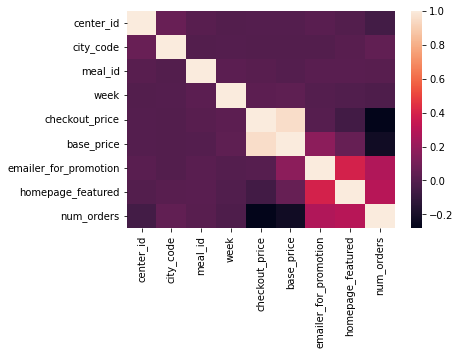

In [16]:
sns.heatmap(train.corr())

## nothing interesting about the corelations

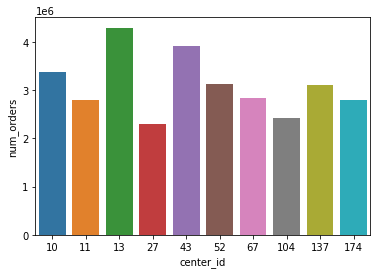

In [17]:
center=train.groupby("center_id",as_index=False).sum()
center=center[["center_id","num_orders"]].sort_values(by="num_orders",ascending=False).head(10)
fig=sns.barplot(x=center["center_id"],y=center["num_orders"])


In [54]:
train['category'].value_counts()

Beverages       127890
Rice Bowl        33408
Sandwich         33291
Pizza            33138
Starters         29941
Other Snacks     29379
Desert           29294
Salad            28559
Pasta            27694
Seafood          26916
Biryani          20614
Extras           13562
Soup             12675
Fish             10187
Name: category, dtype: int64

Text(0.5, 0.98, 'popular food categories')

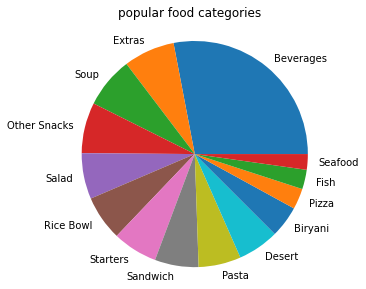

In [80]:
plt.pie(train['category'].value_counts(),labels=train['category'].unique(),radius=1.3)
plt.suptitle('popular food categories', horizontalalignment = 'center' , verticalalignment='baseline')

Text(0.5, 0.98, 'popular cusines')

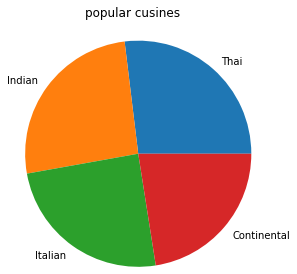

In [83]:
plt.pie(train['cuisine'].value_counts(),labels=train['cuisine'].unique(),radius=1.3 )
plt.suptitle('popular cusines', horizontalalignment = 'center' , verticalalignment='baseline')

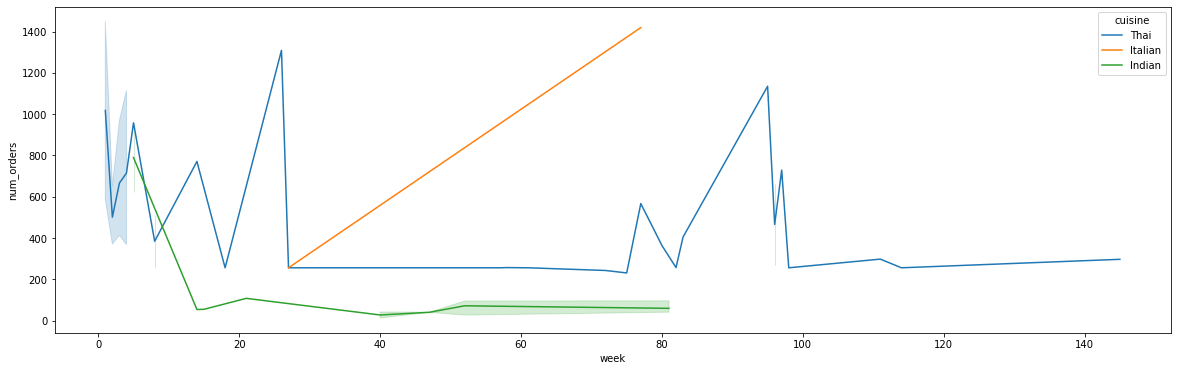

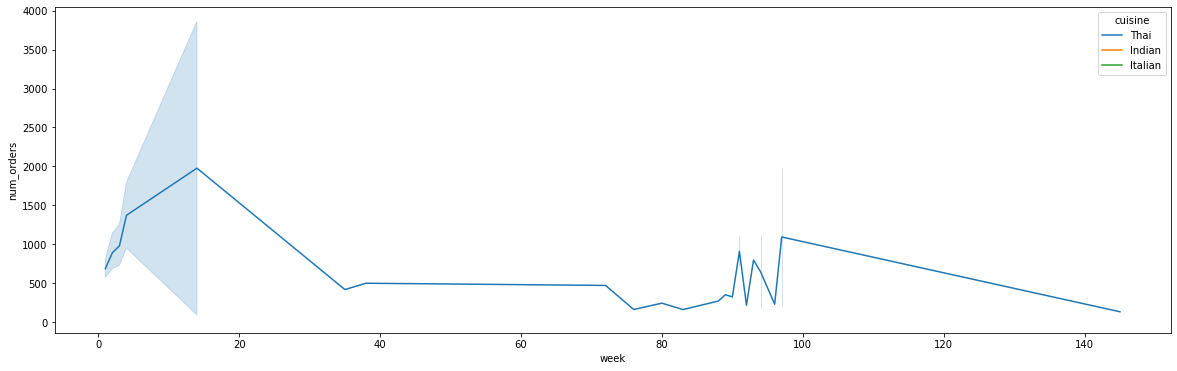

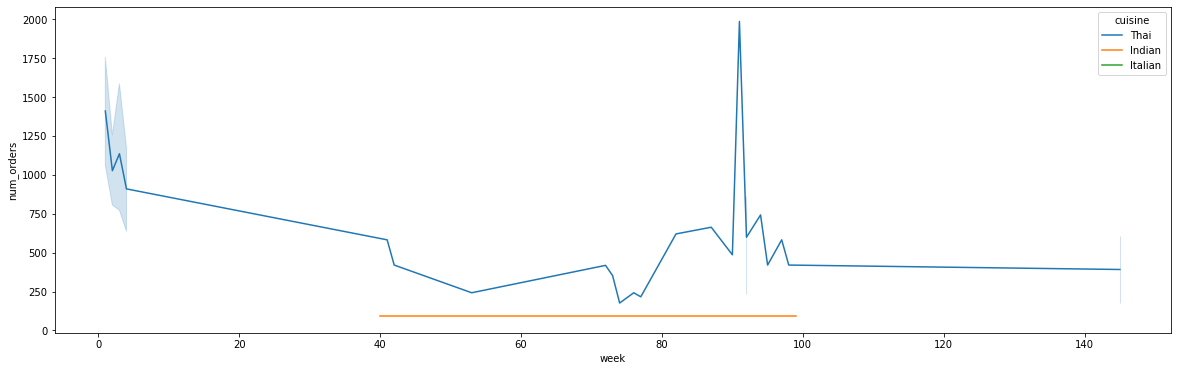

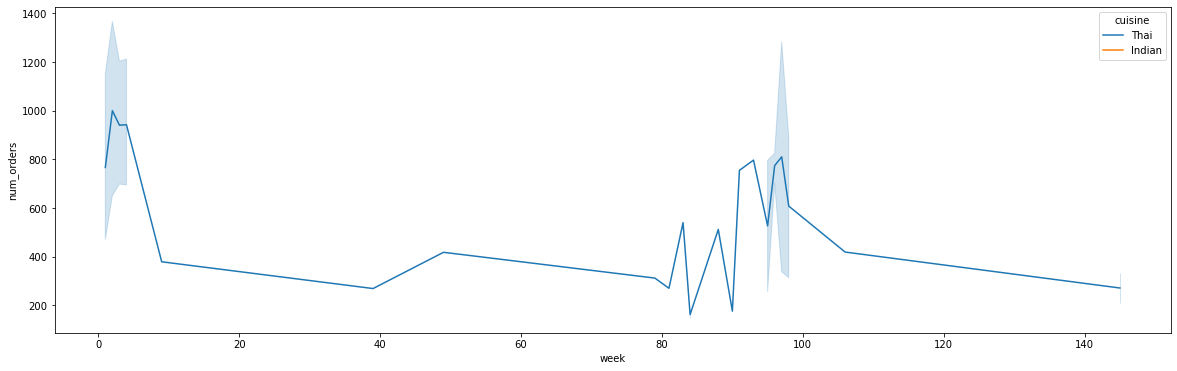

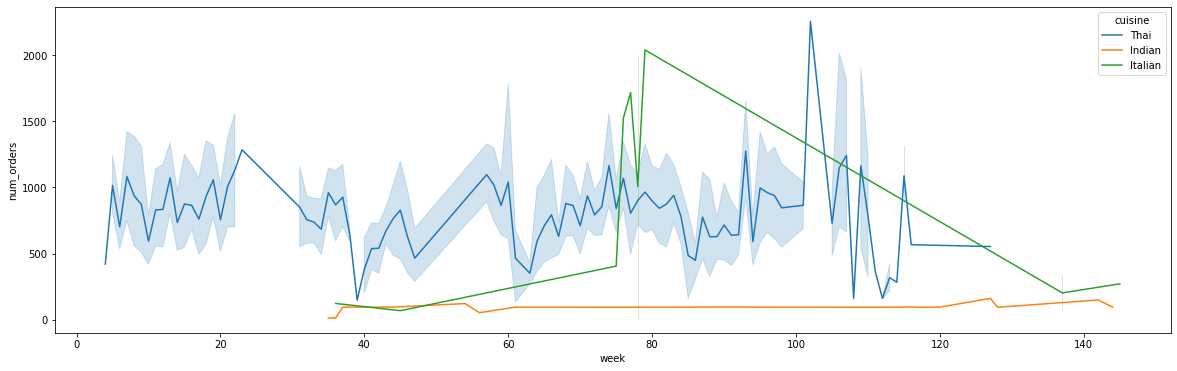

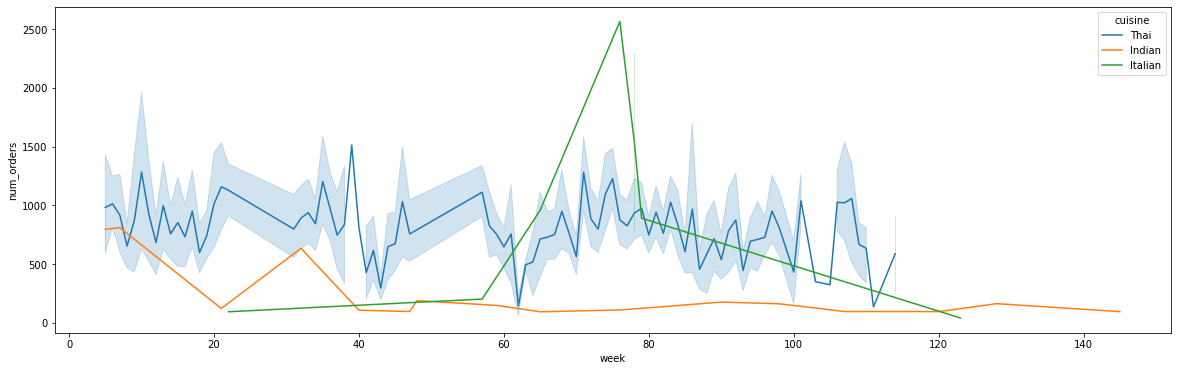

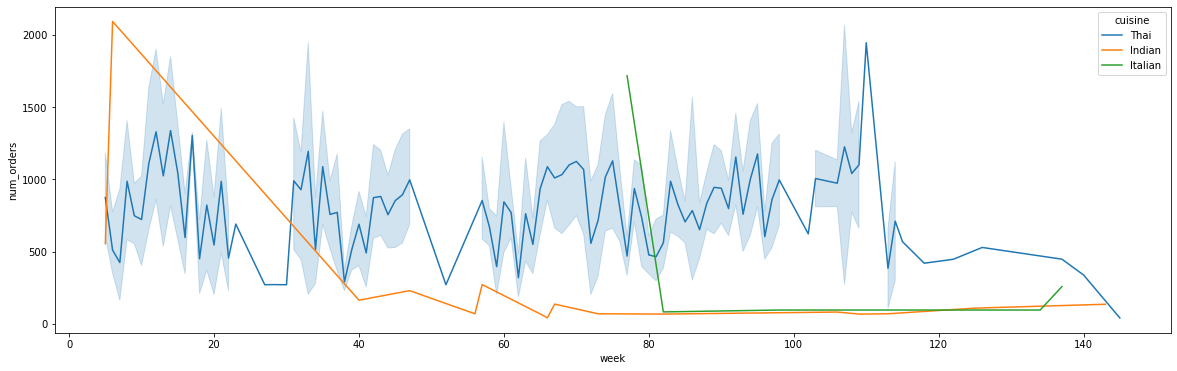

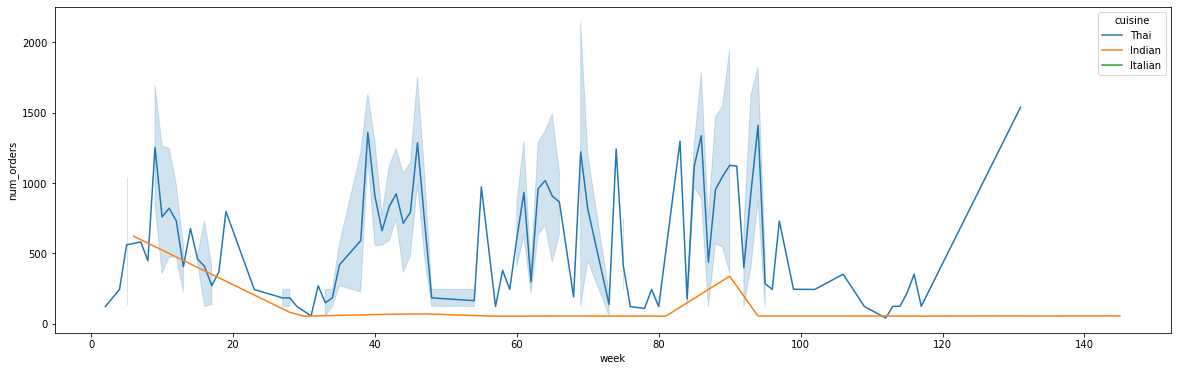

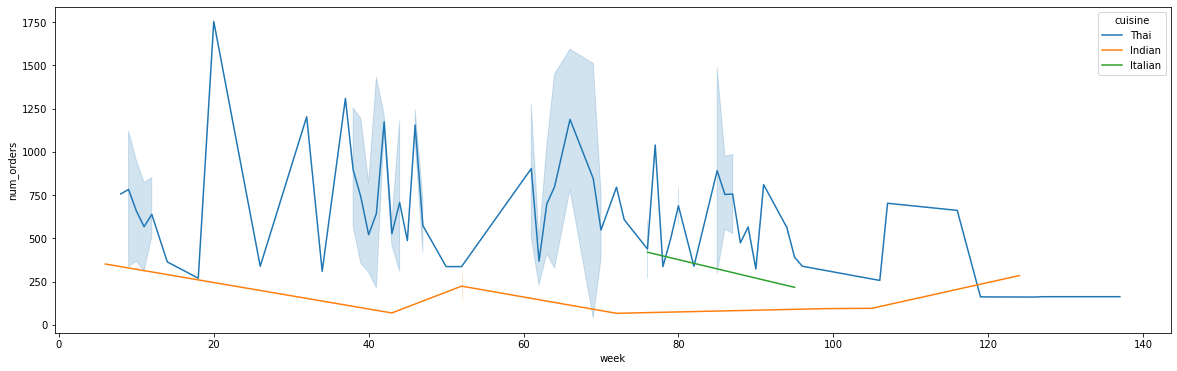

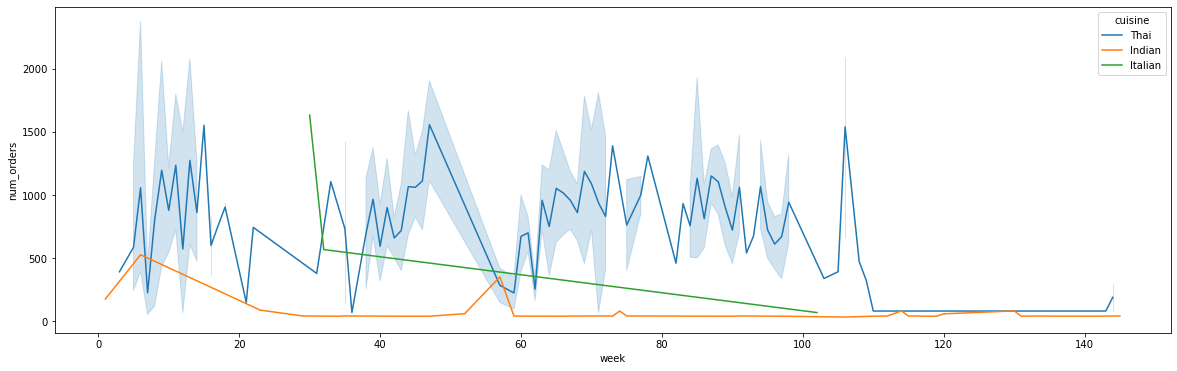

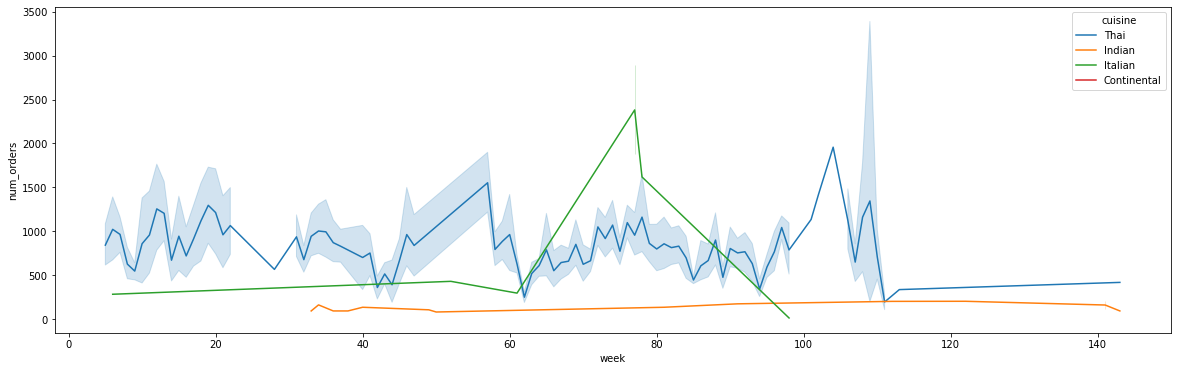

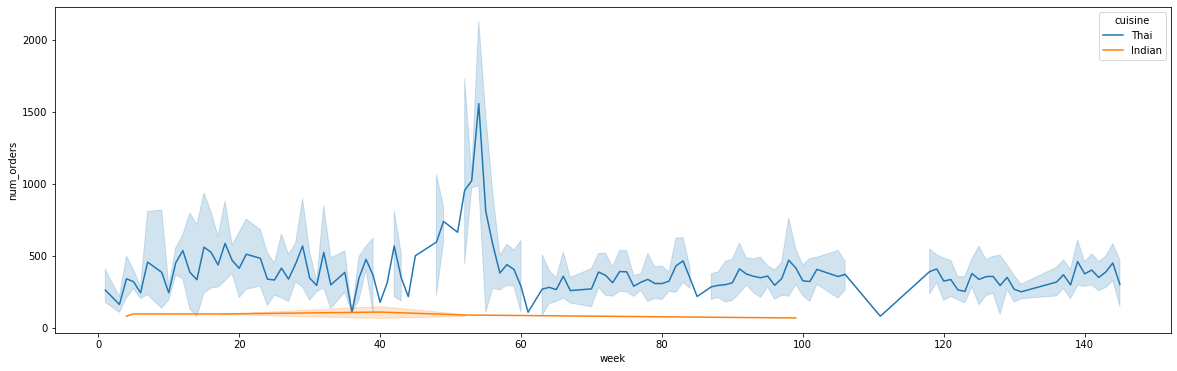

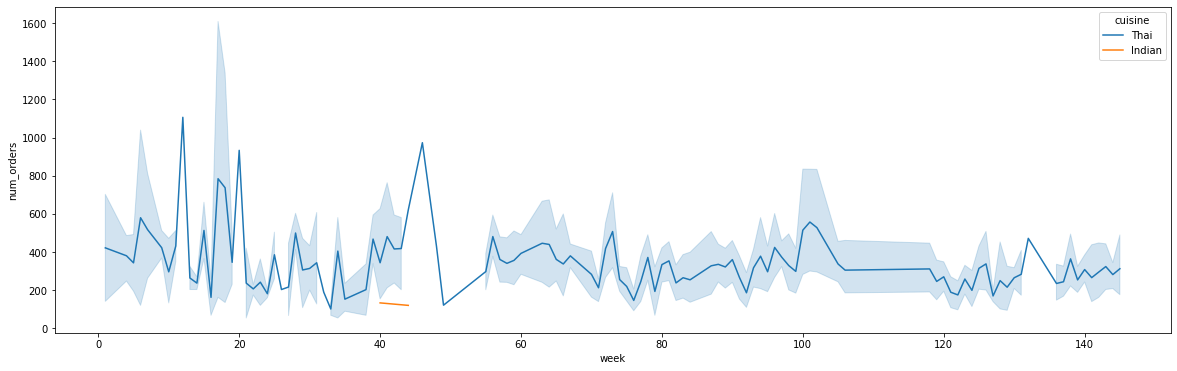

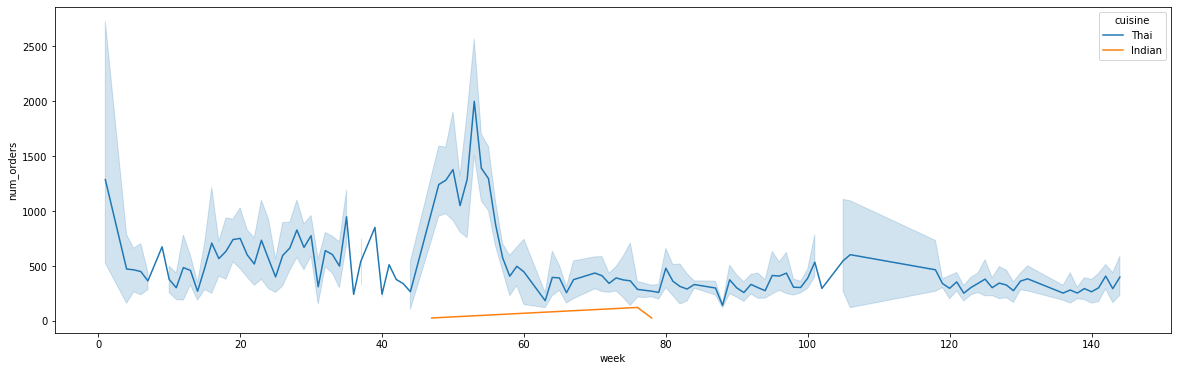

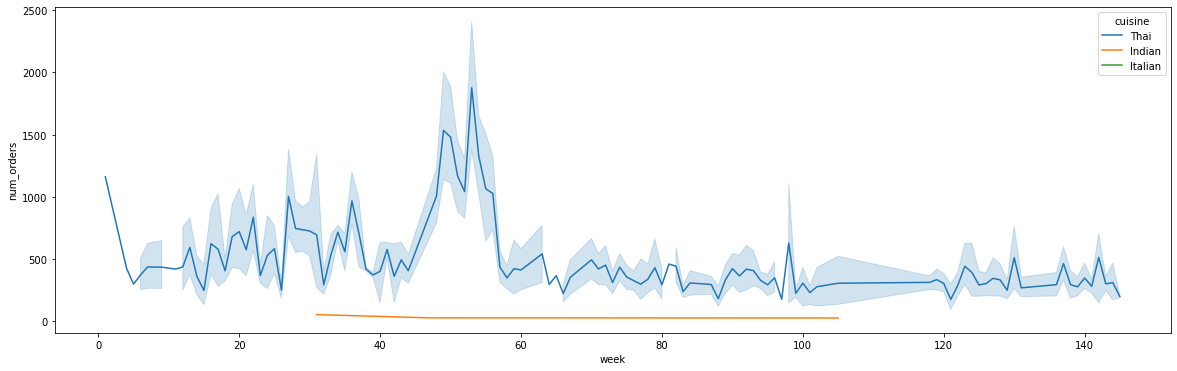

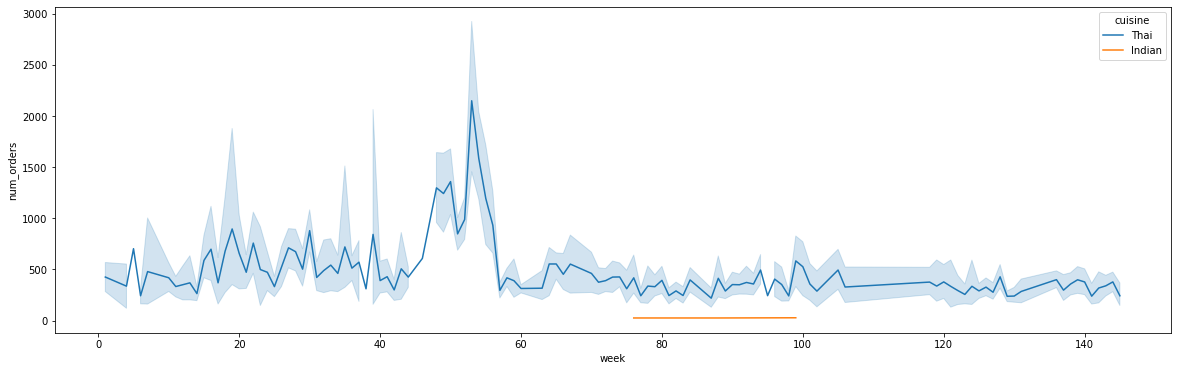

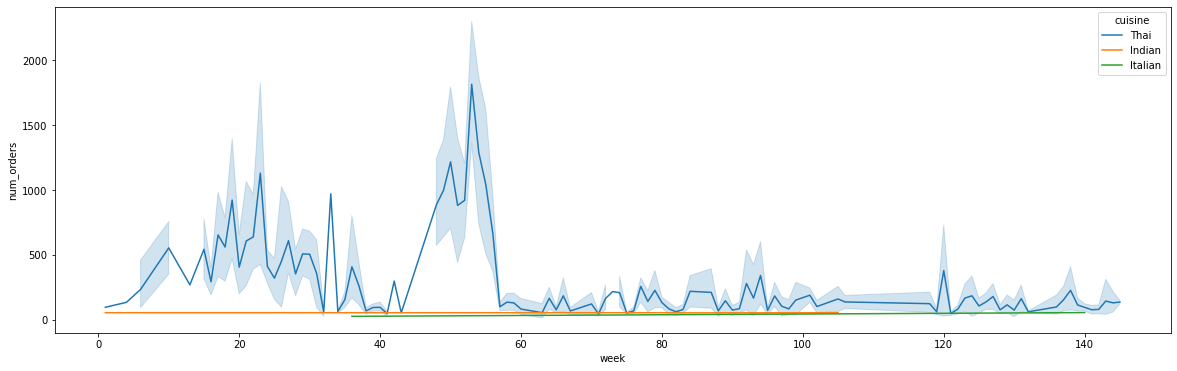

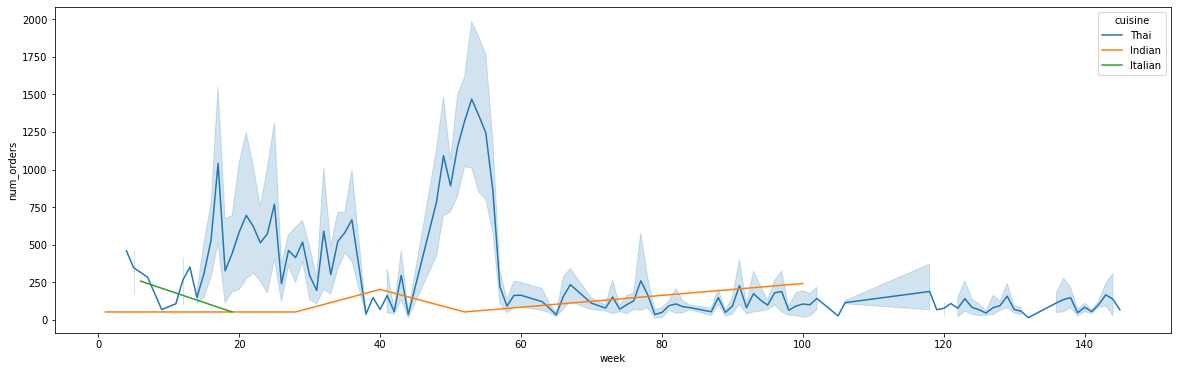

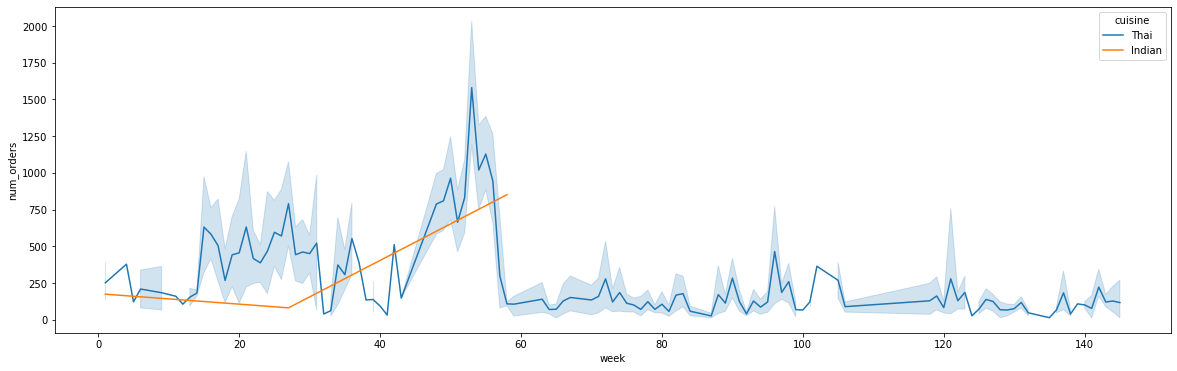

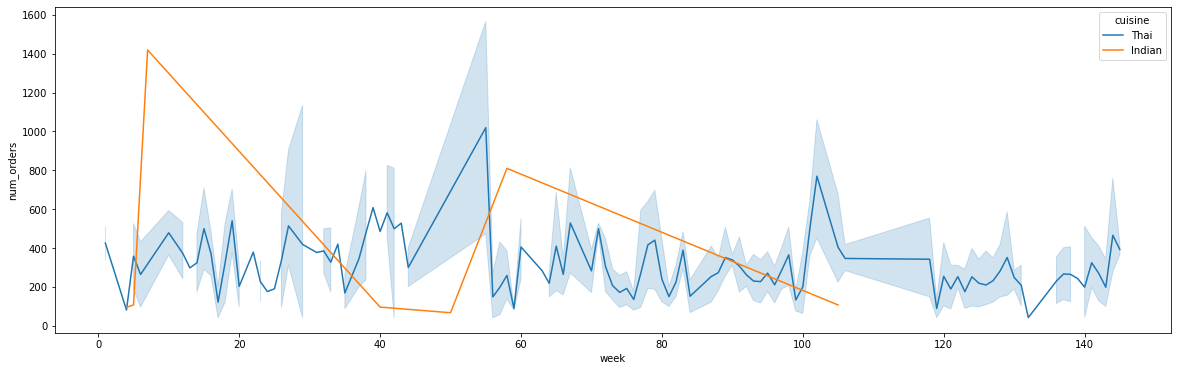

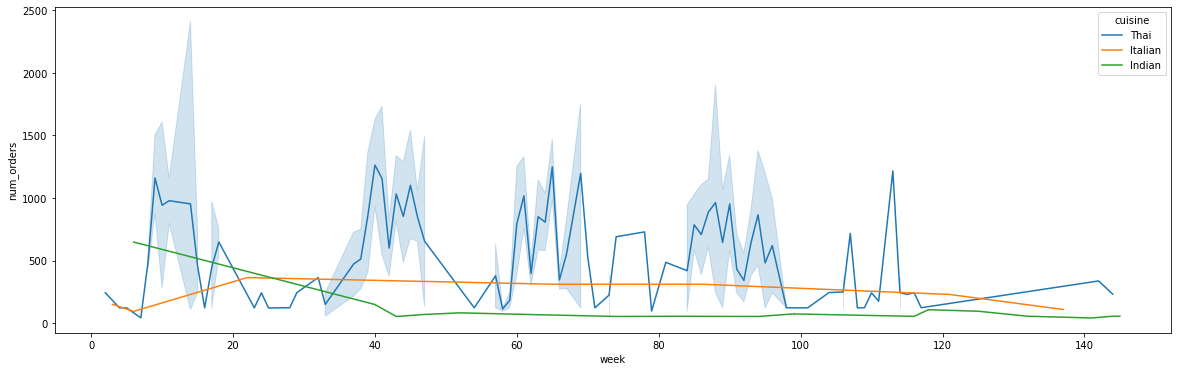

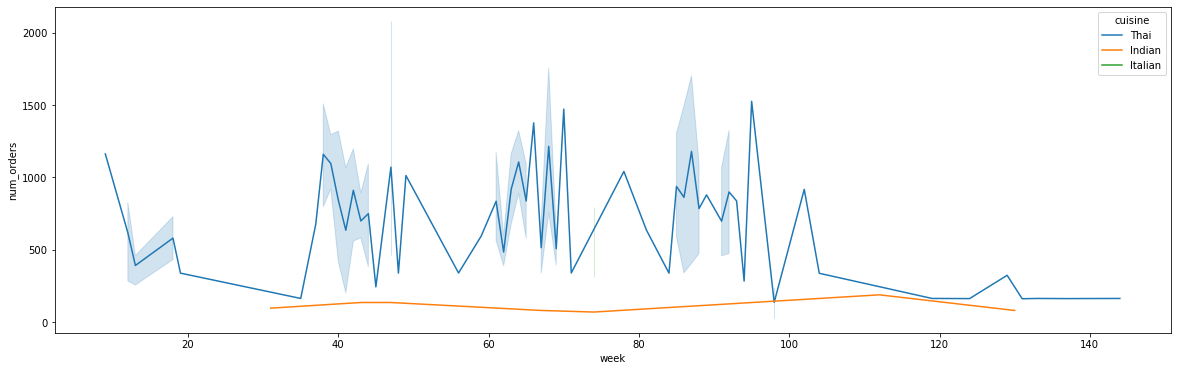

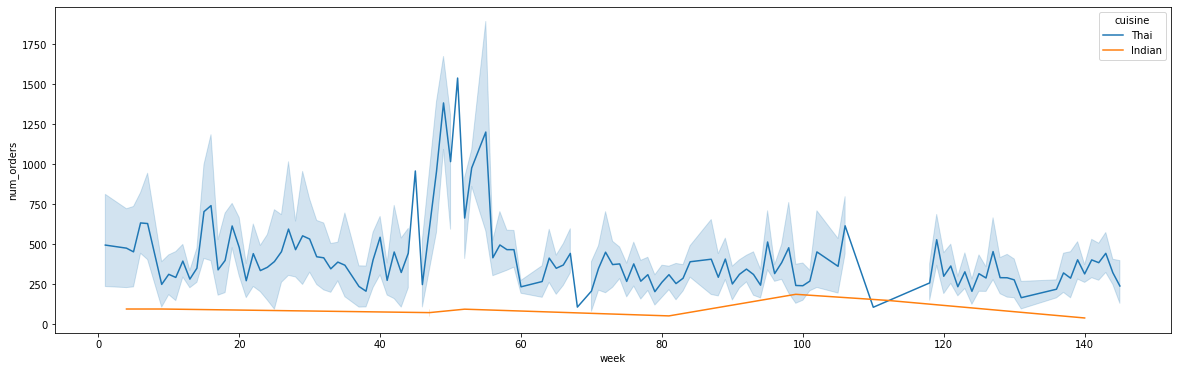

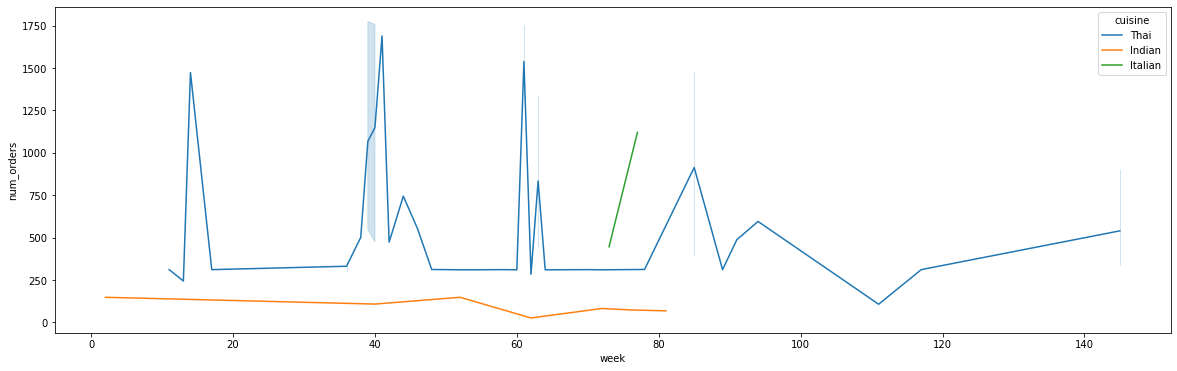

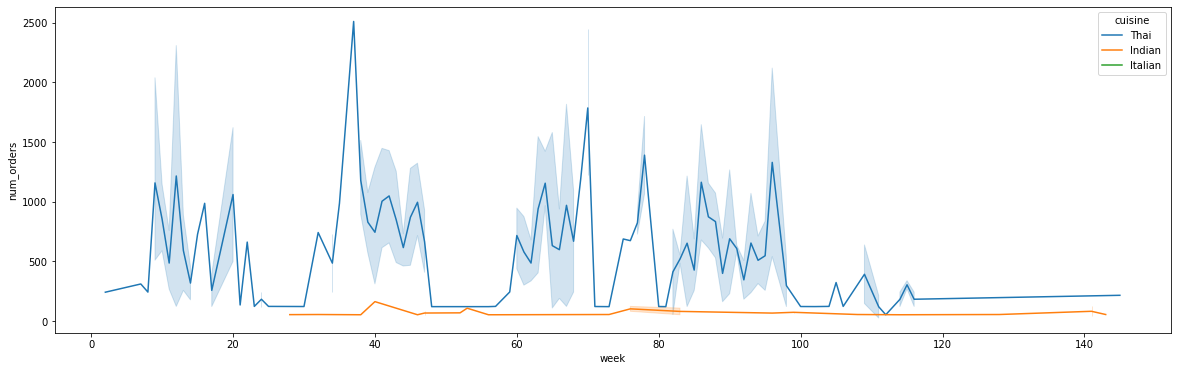

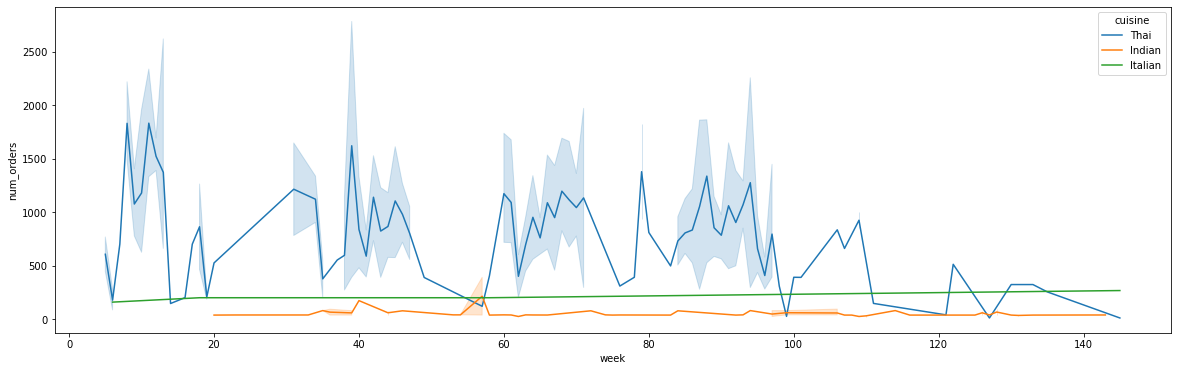

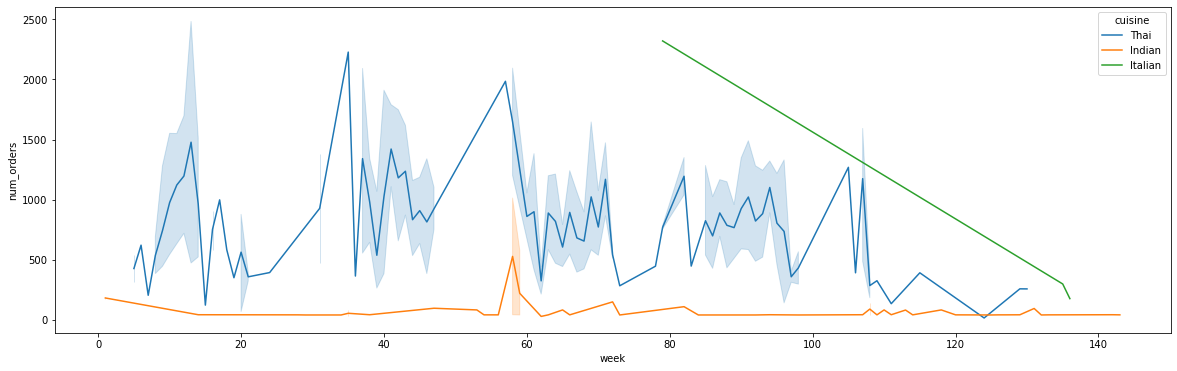

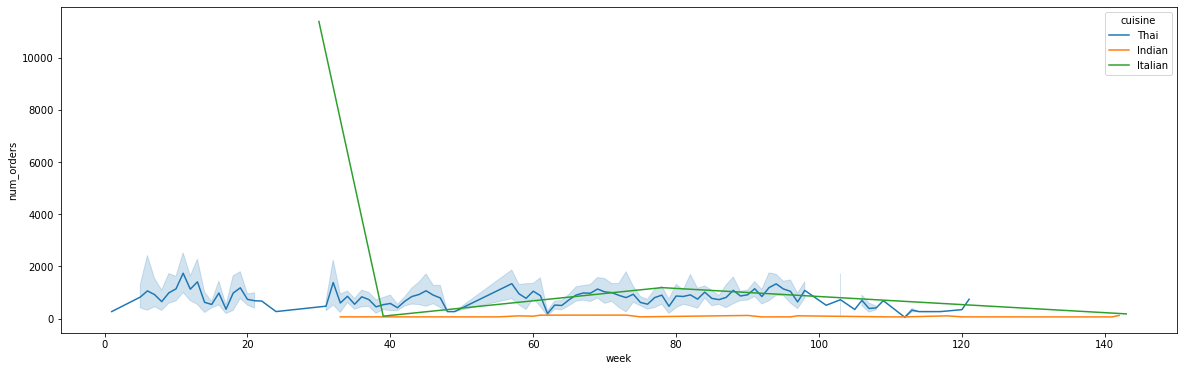

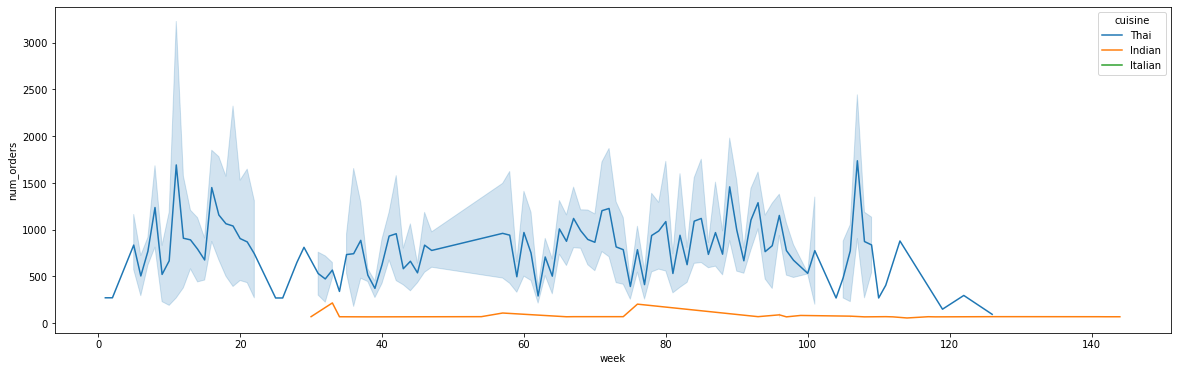

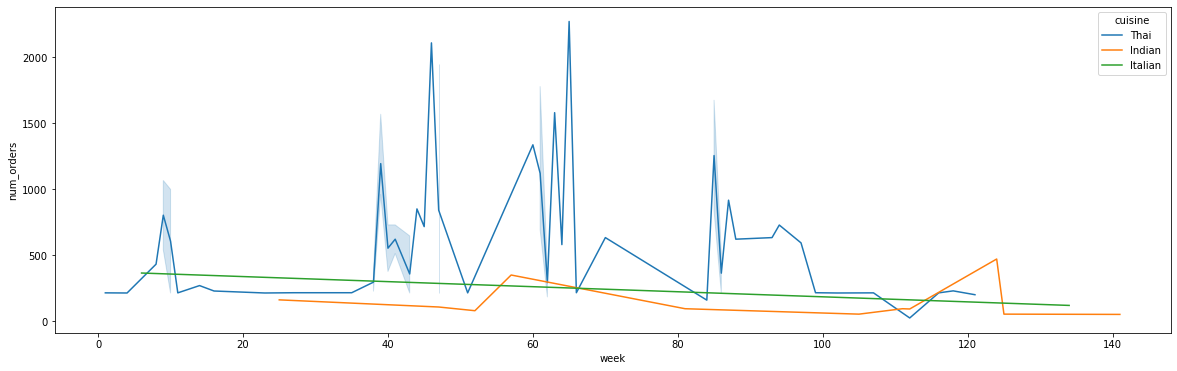

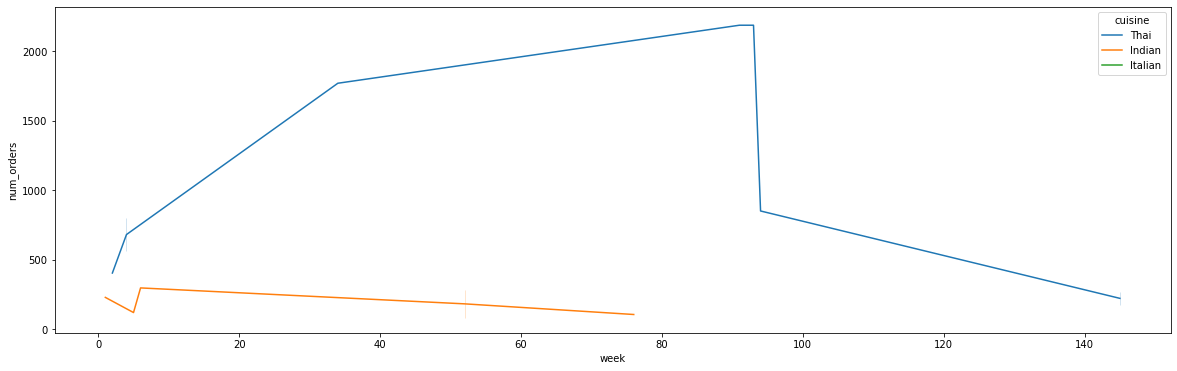

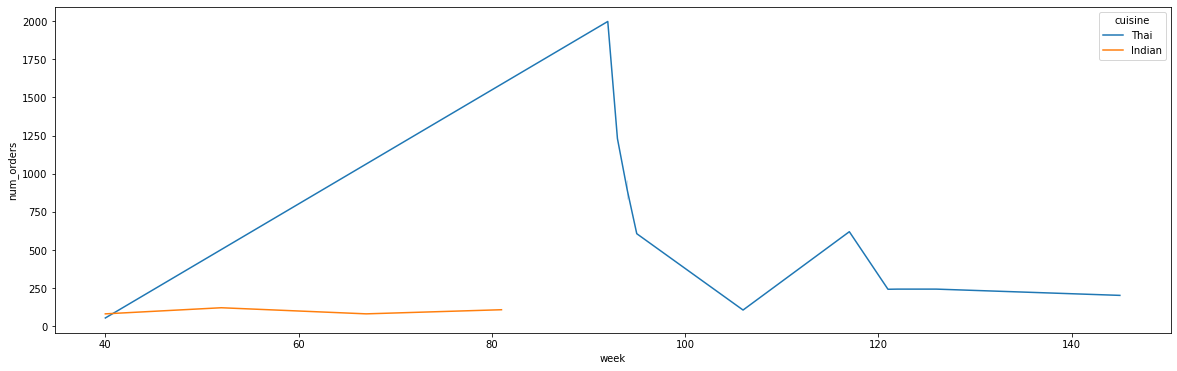

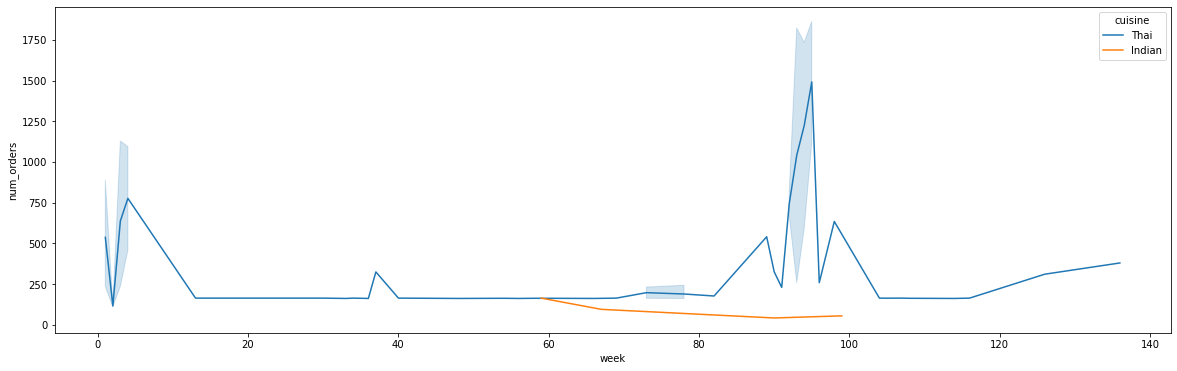

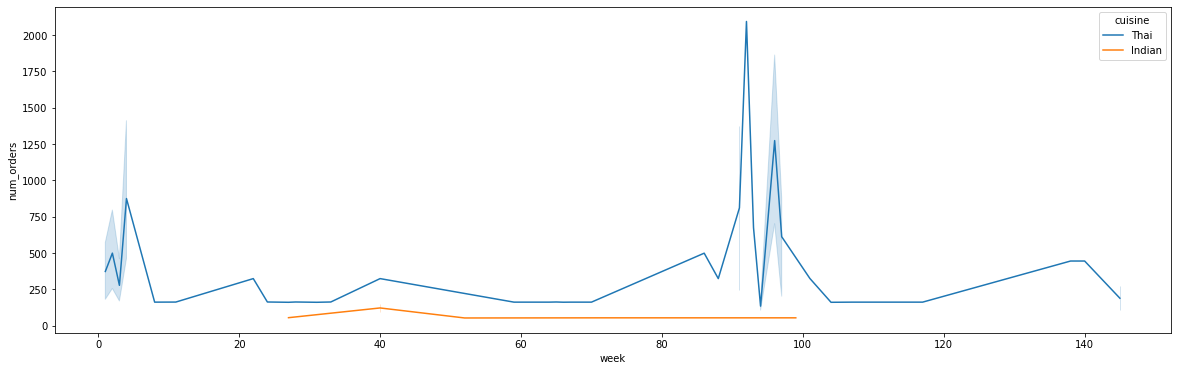

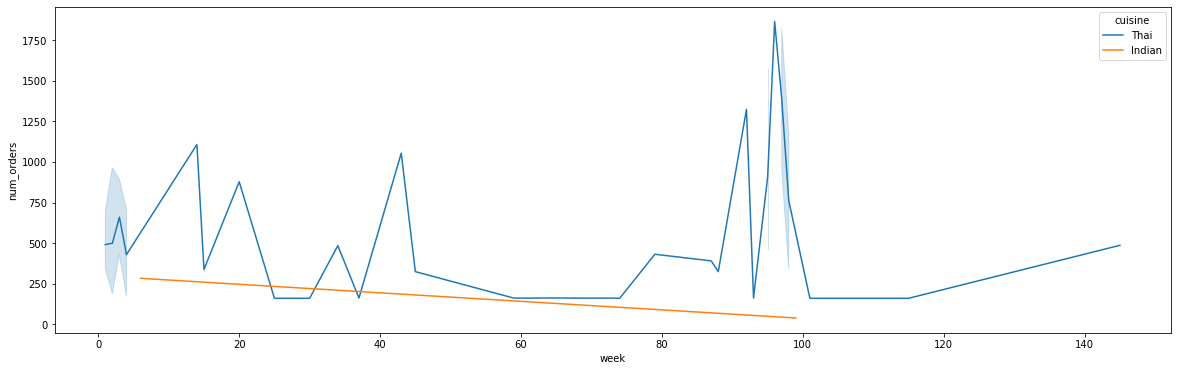

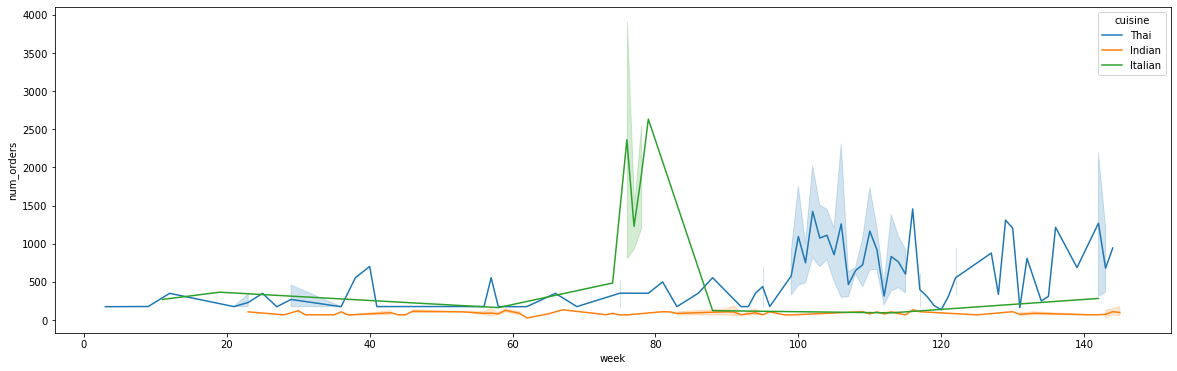

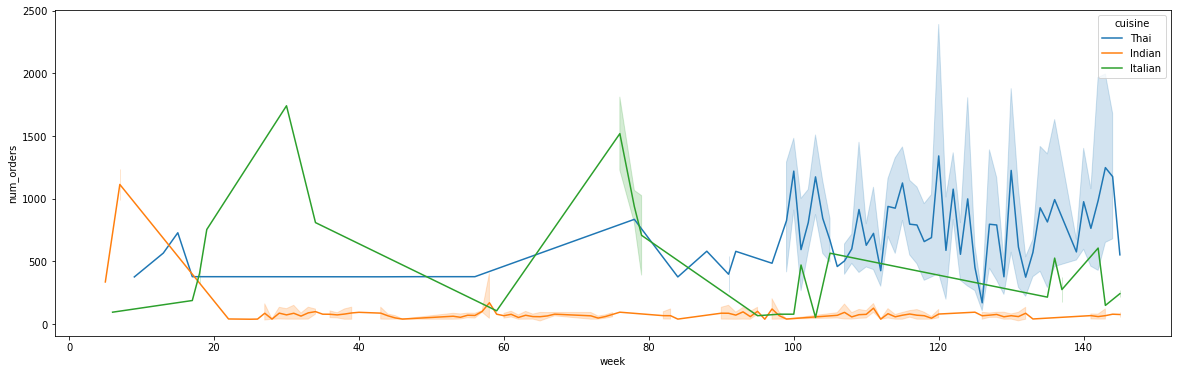

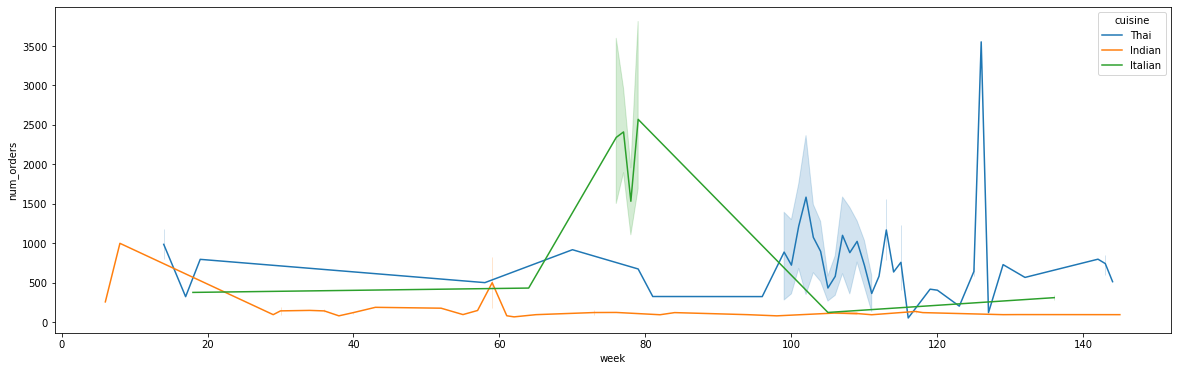

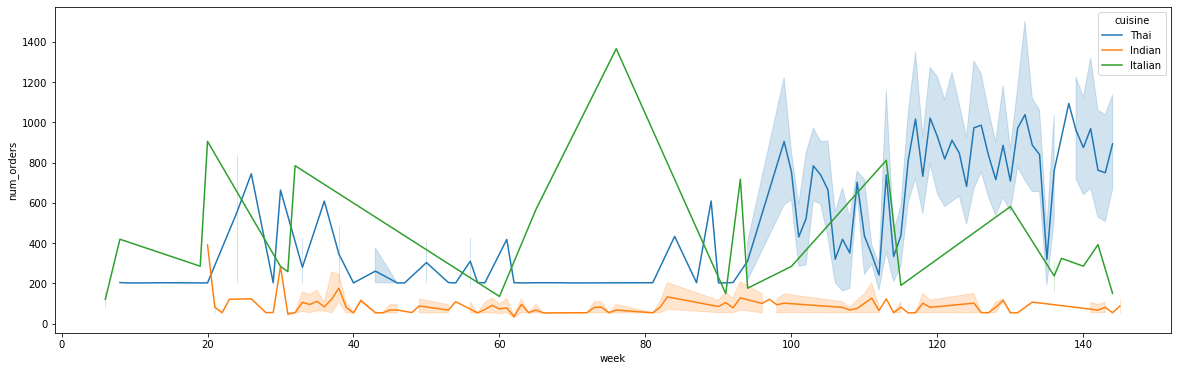

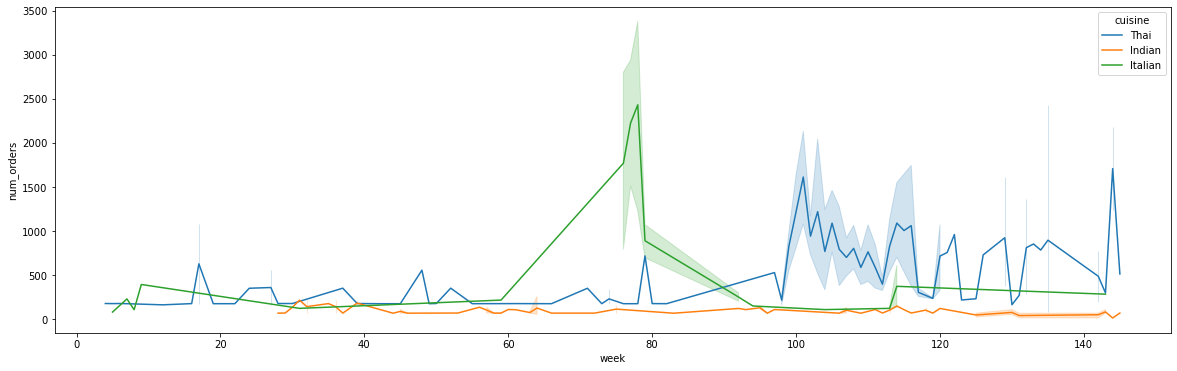

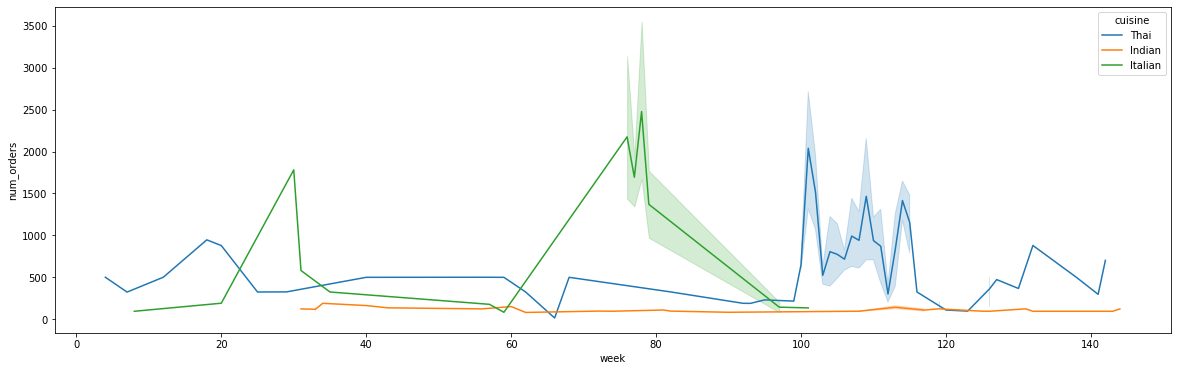

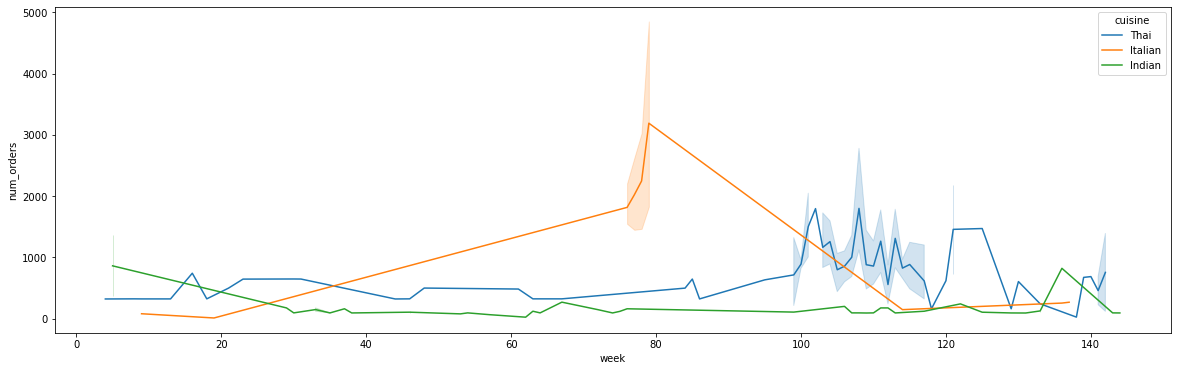

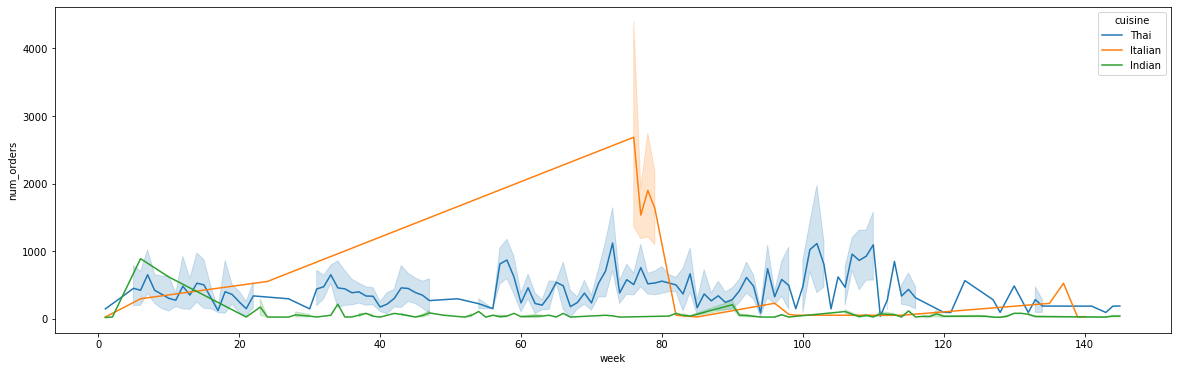

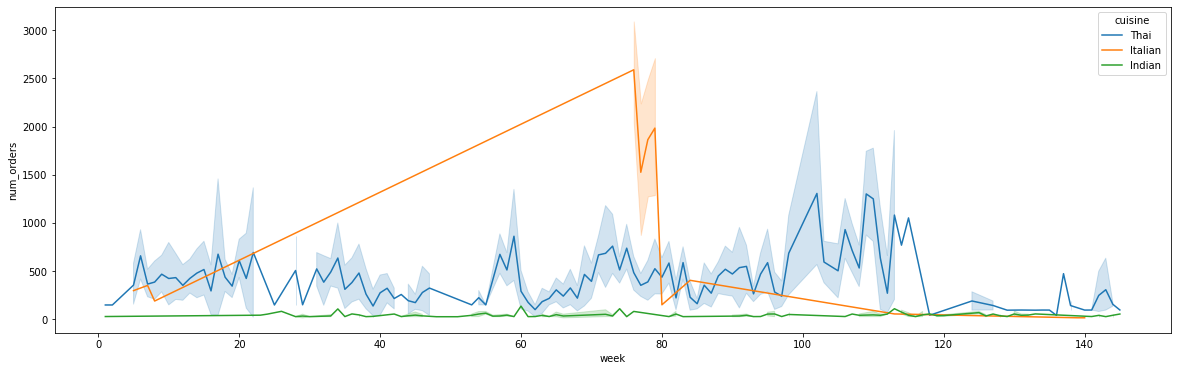

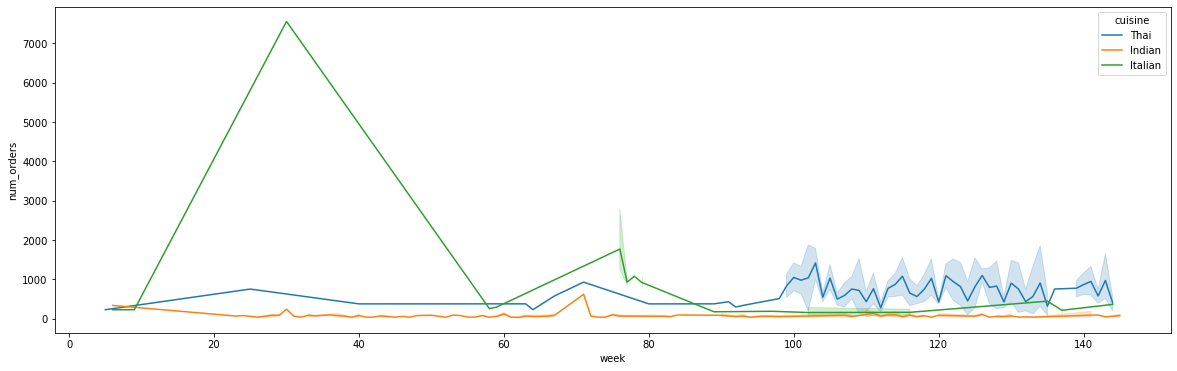

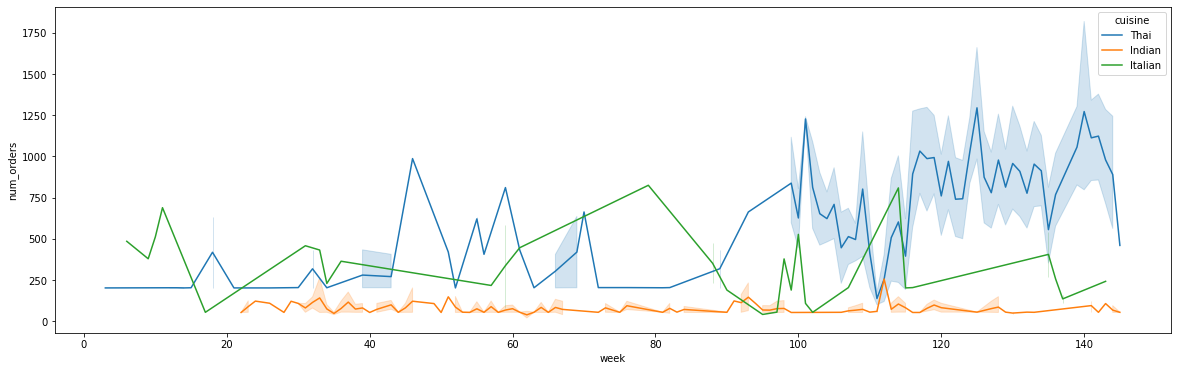

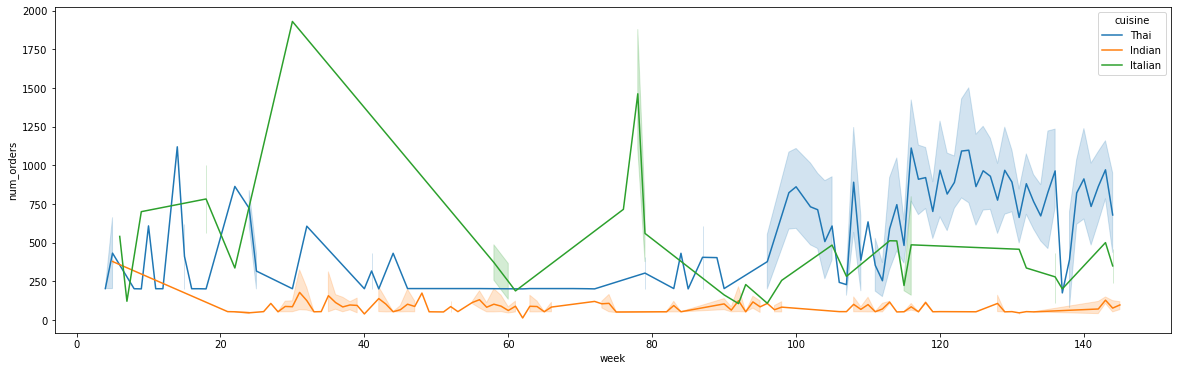

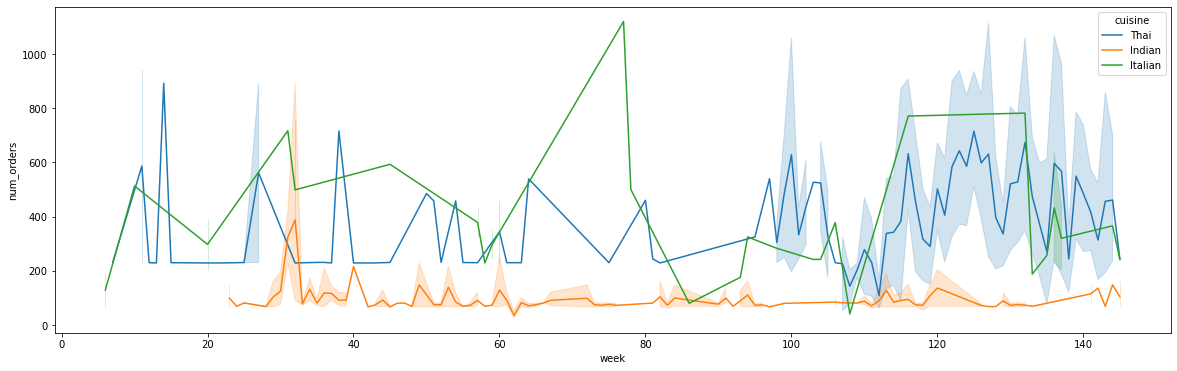

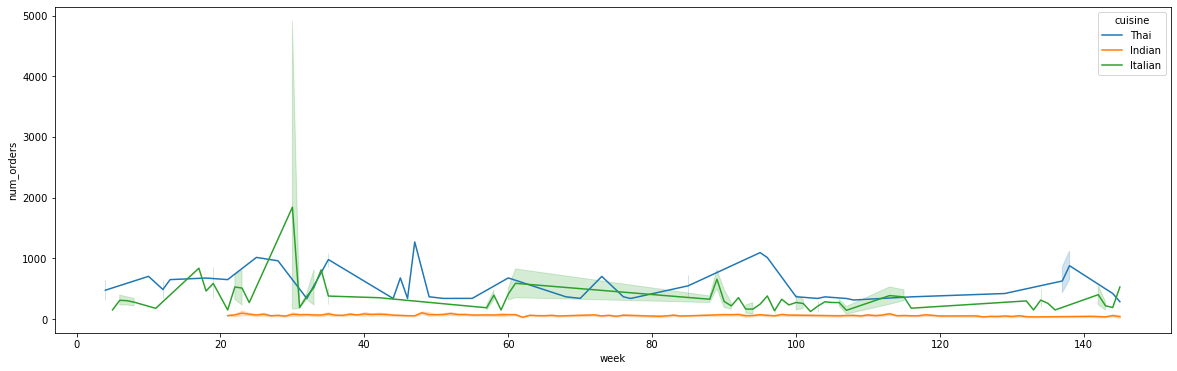

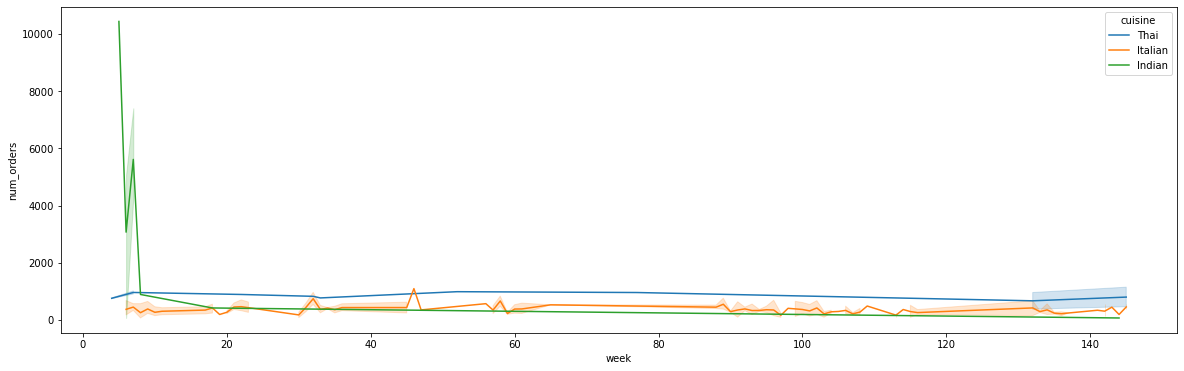

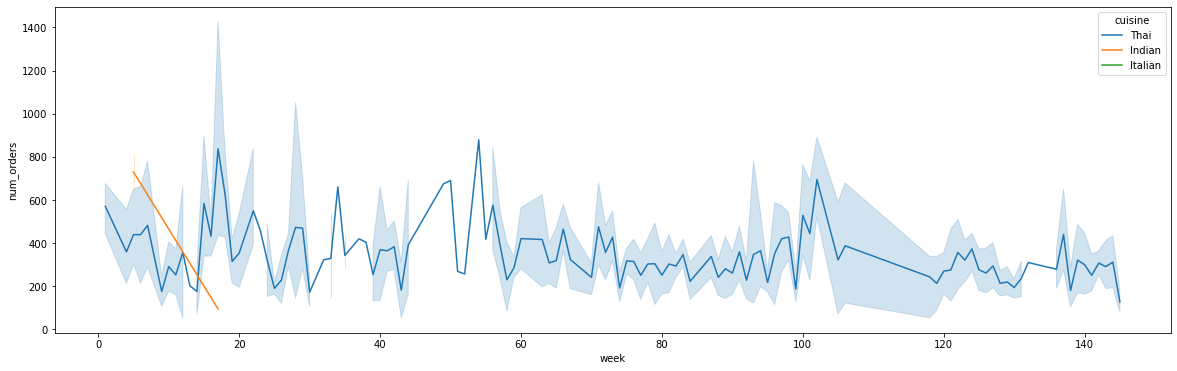

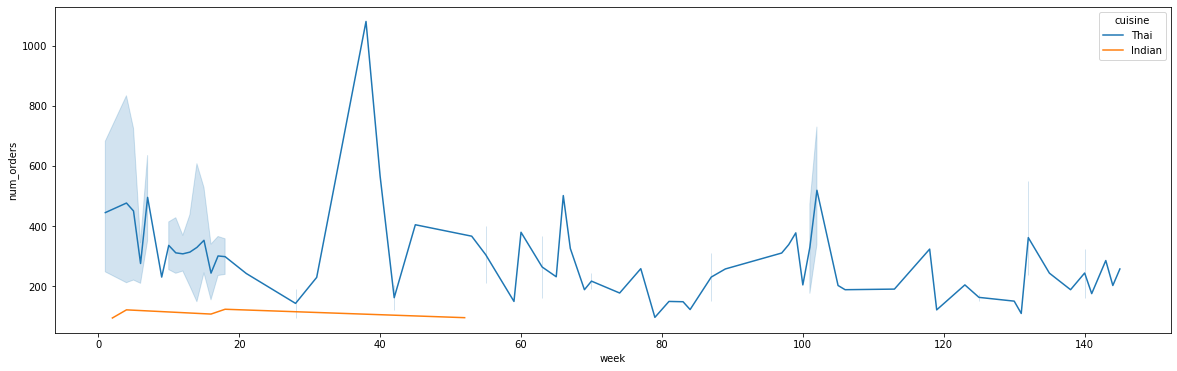

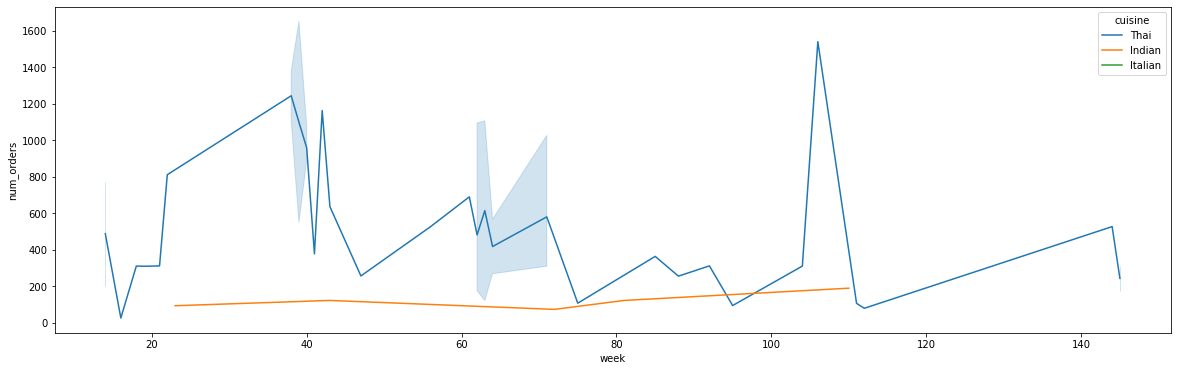

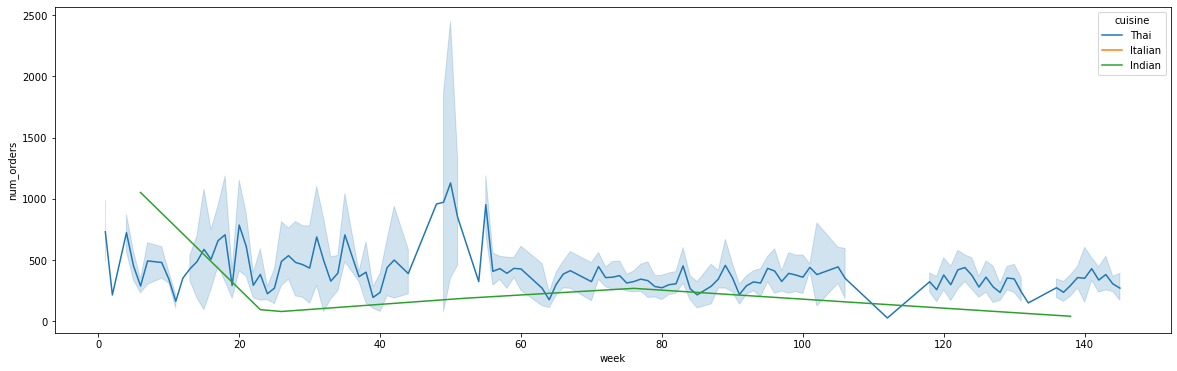

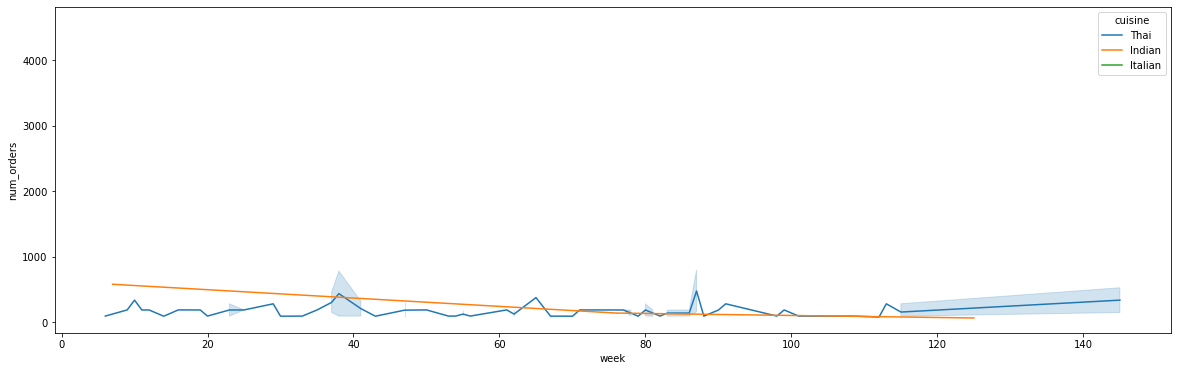

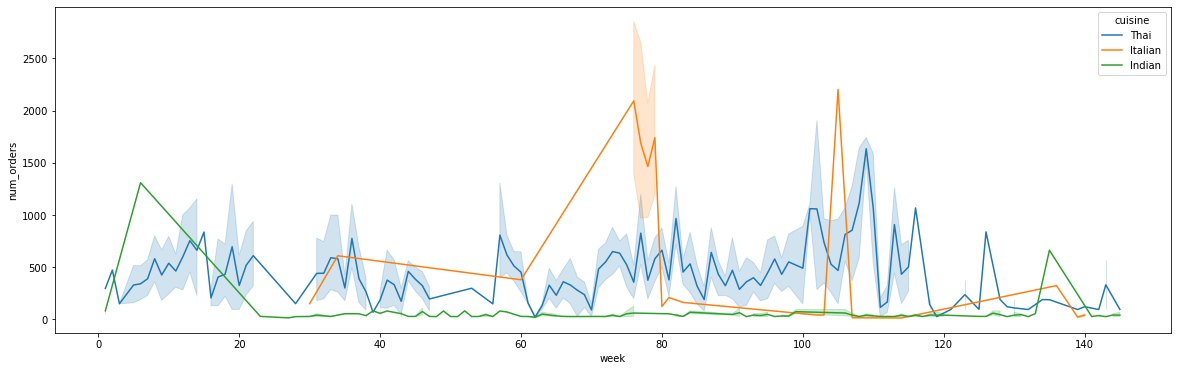

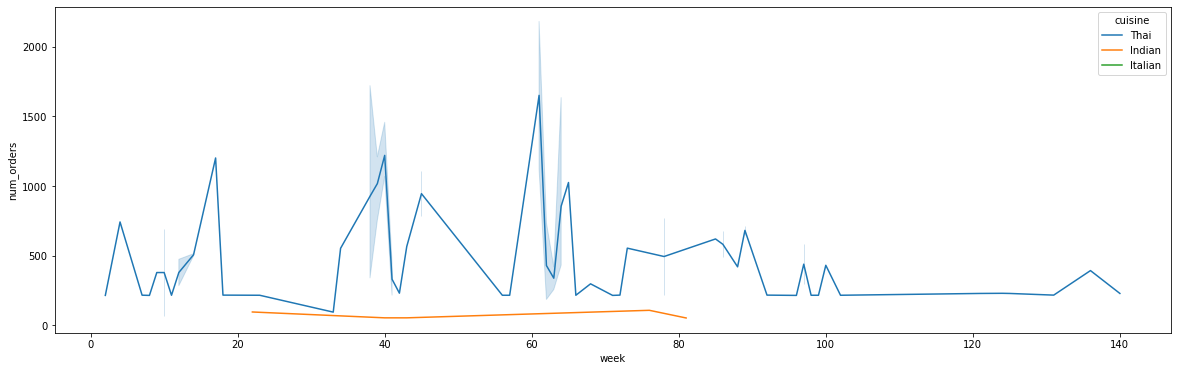

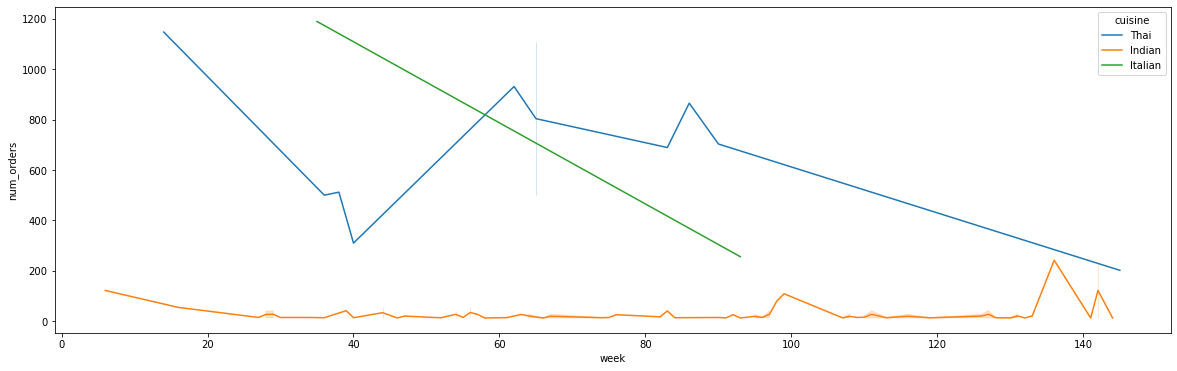

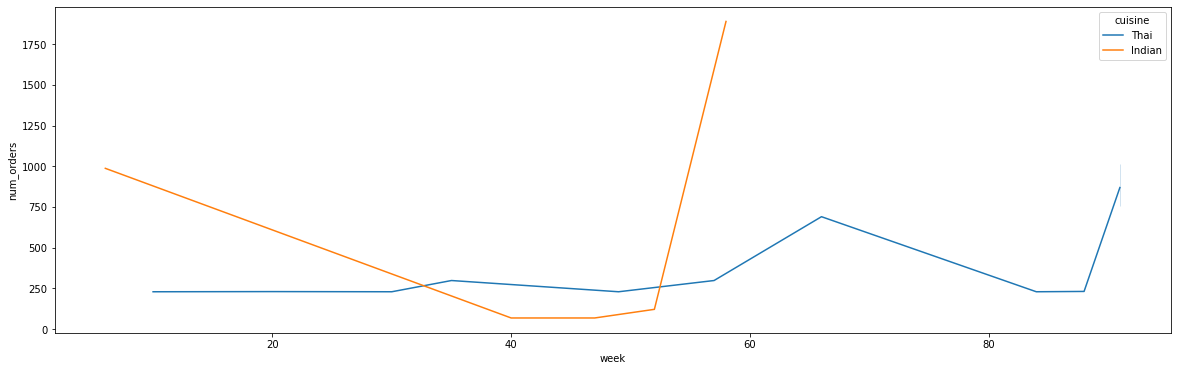

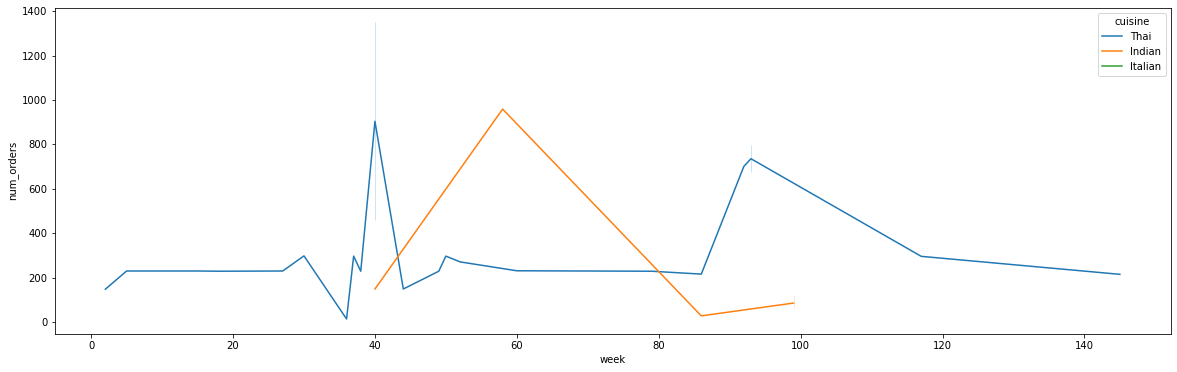

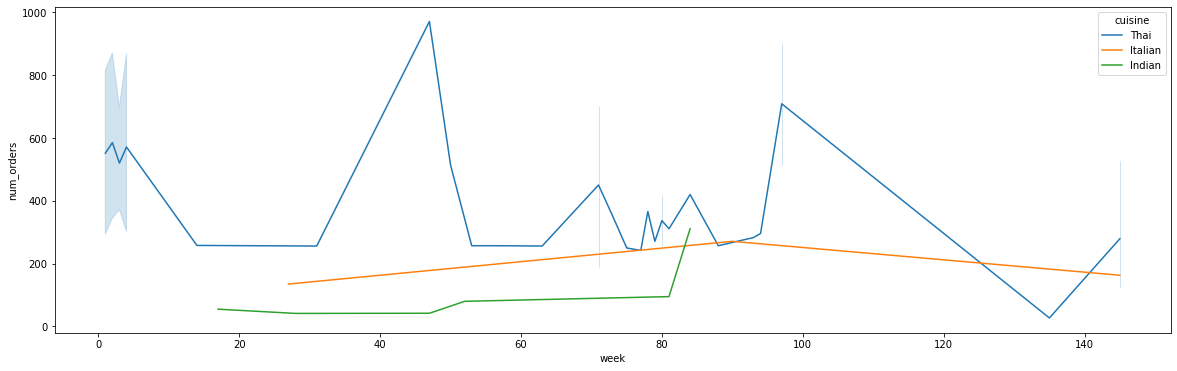

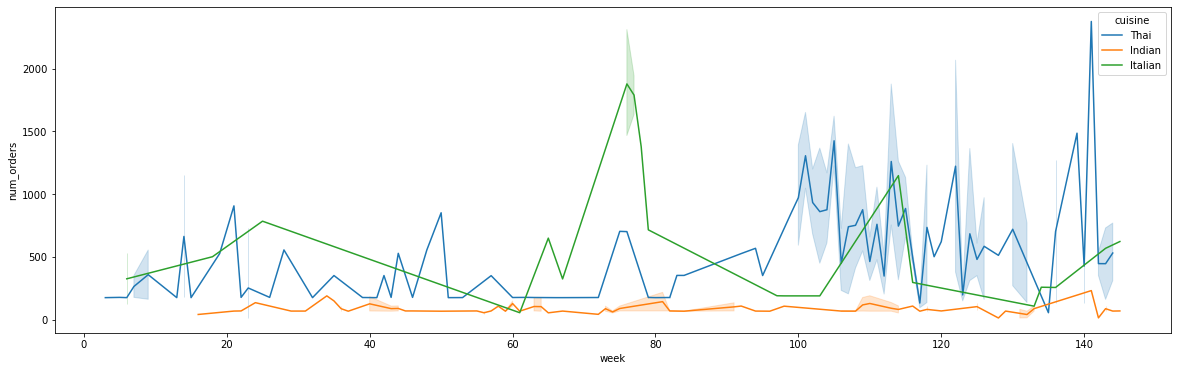

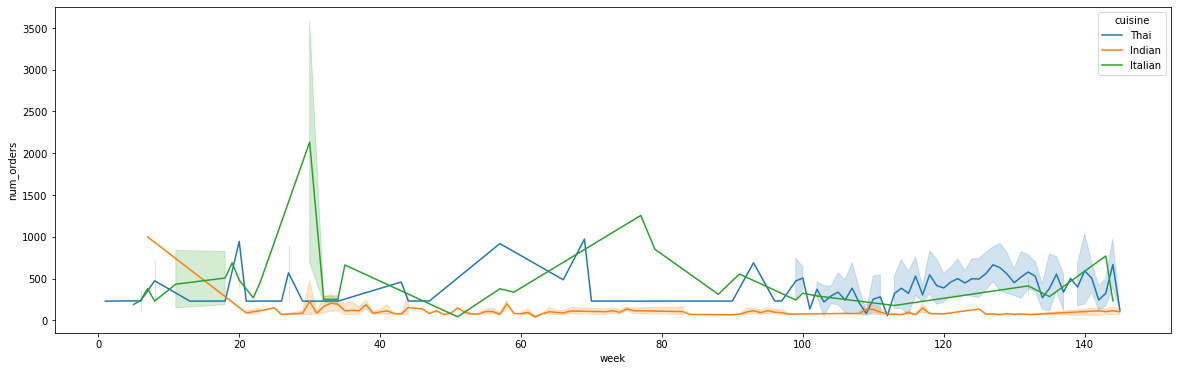

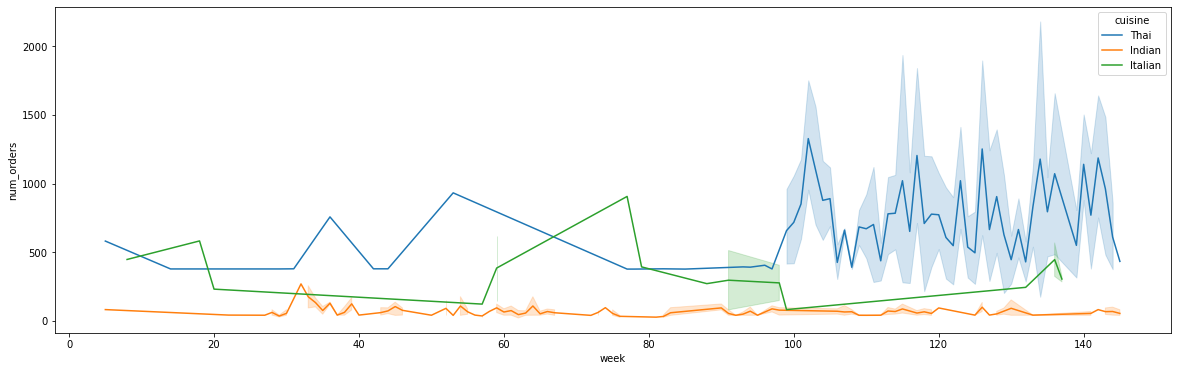

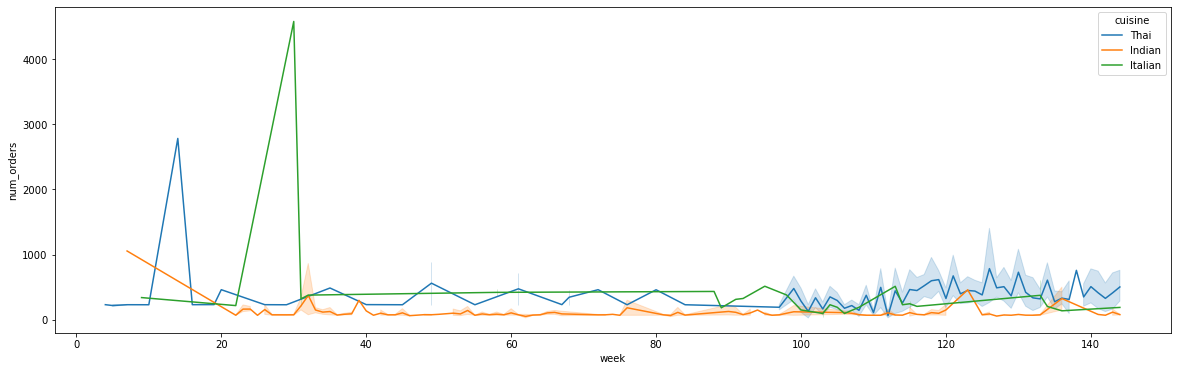

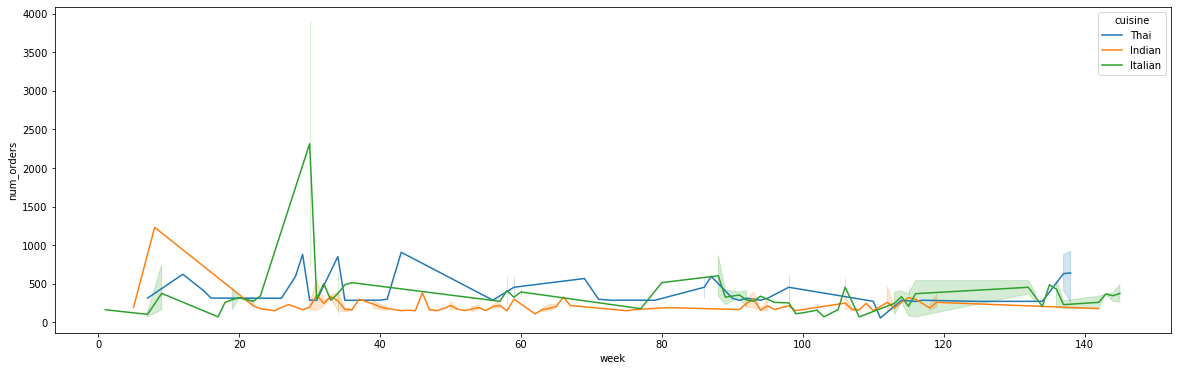

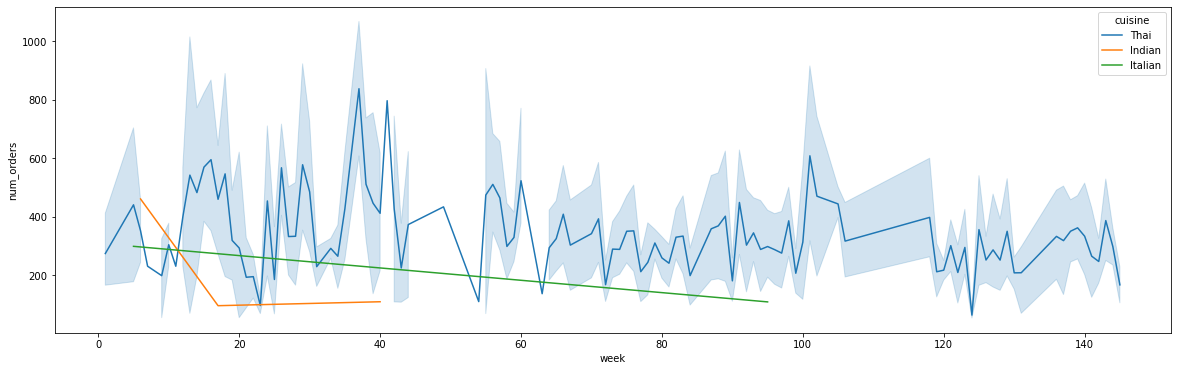

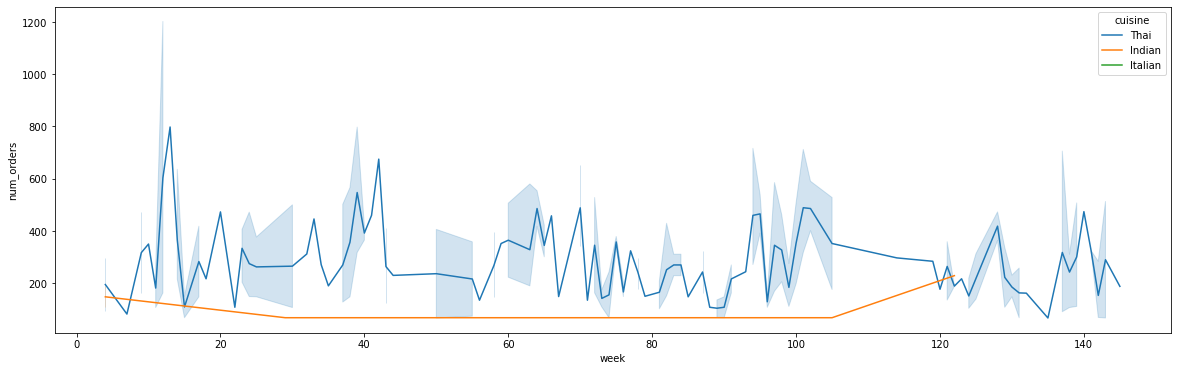

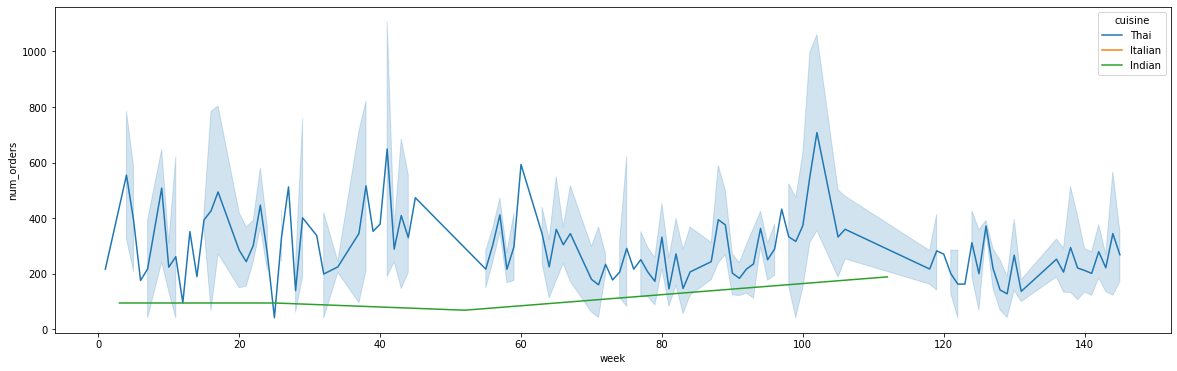

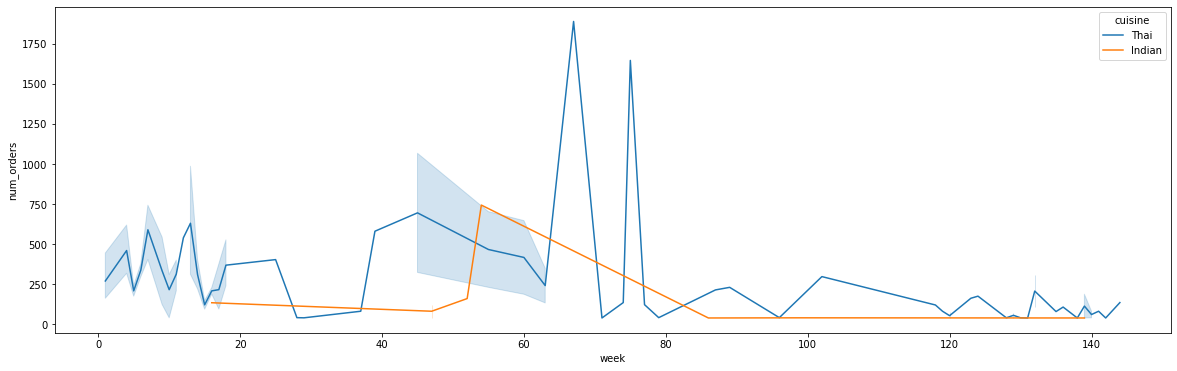

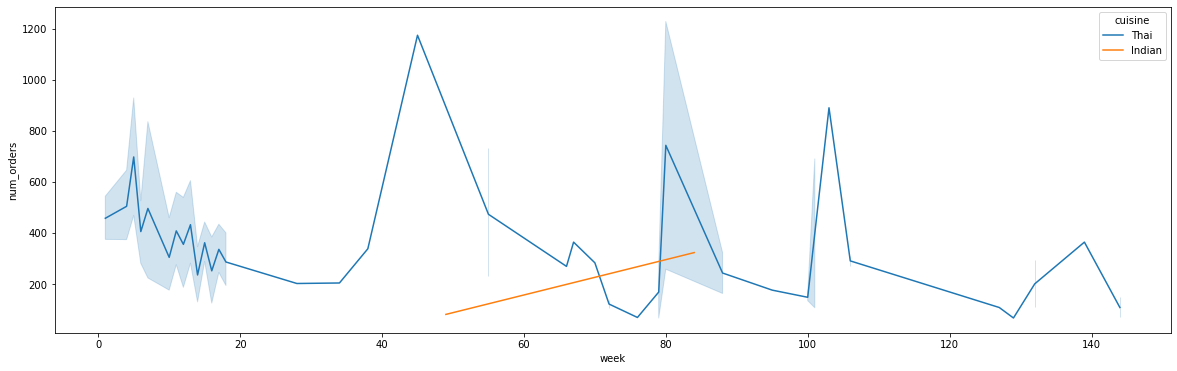

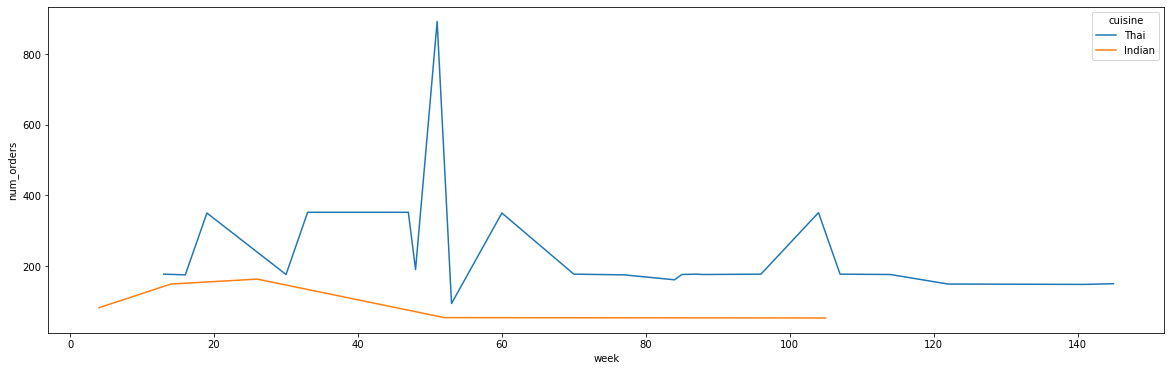

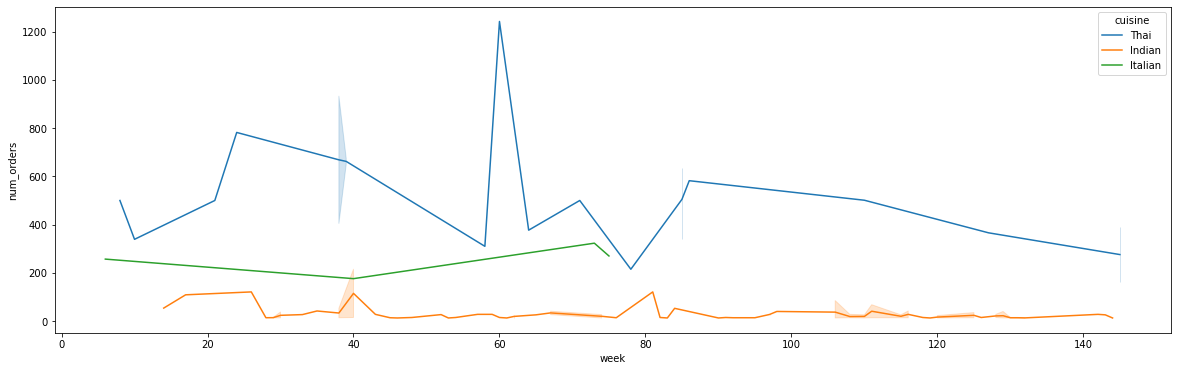

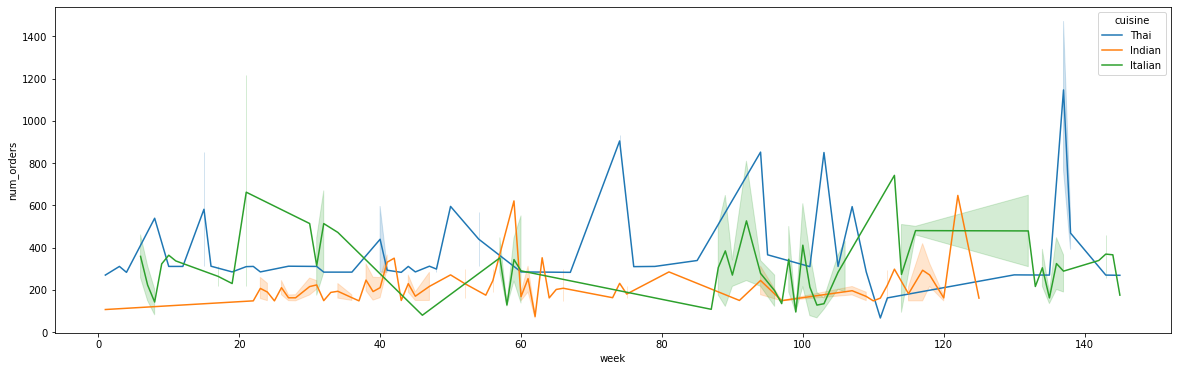

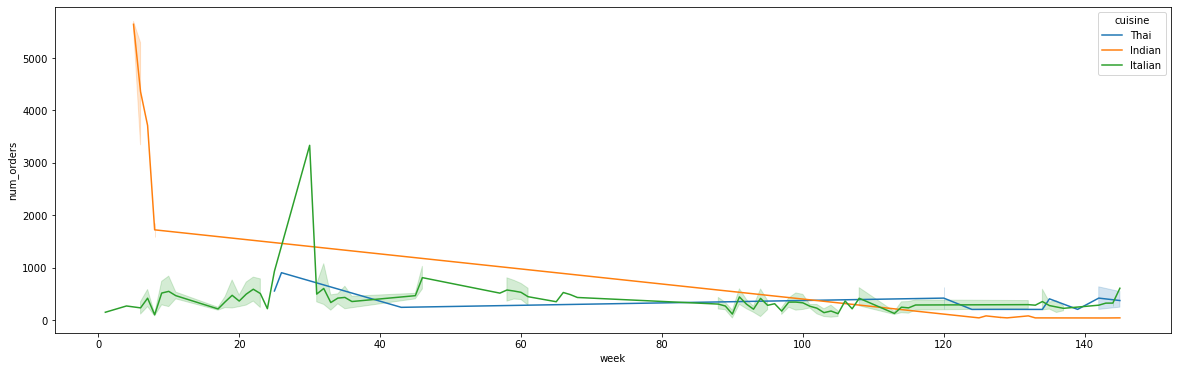

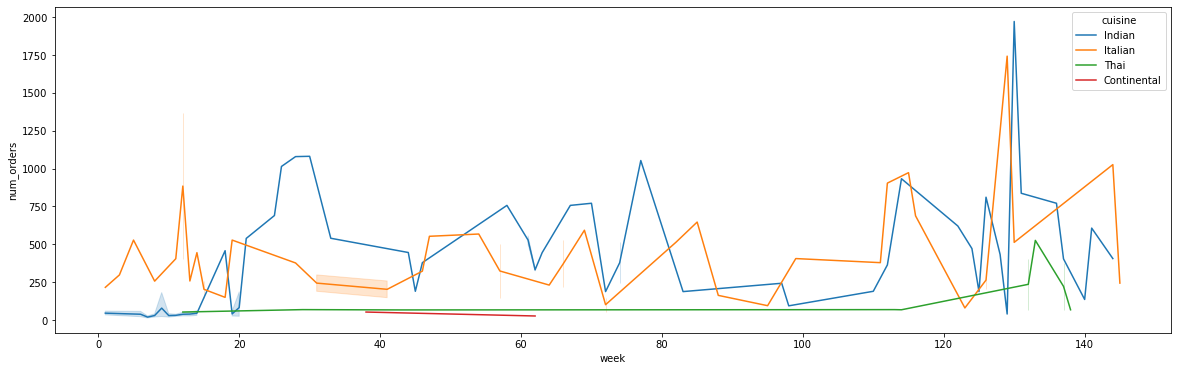

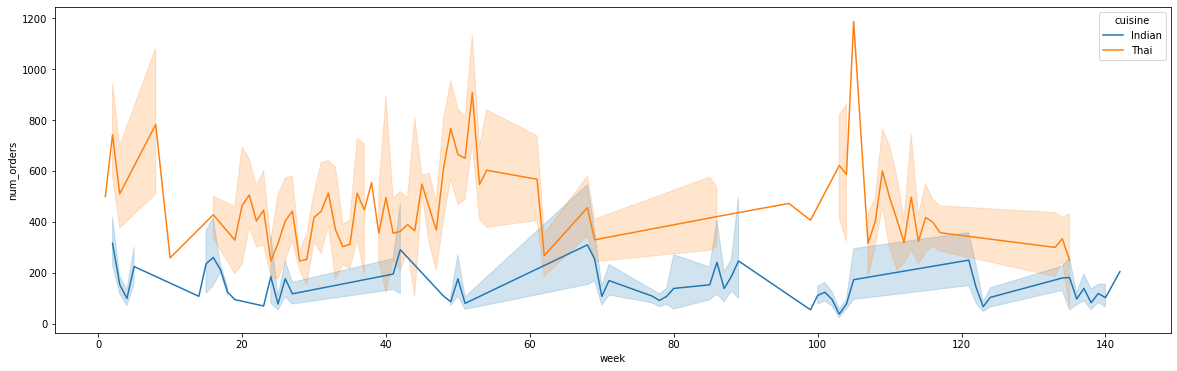

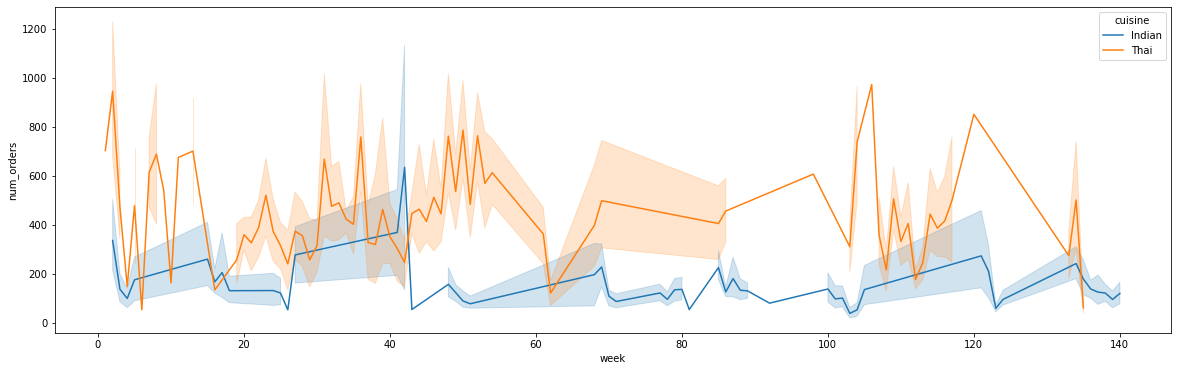

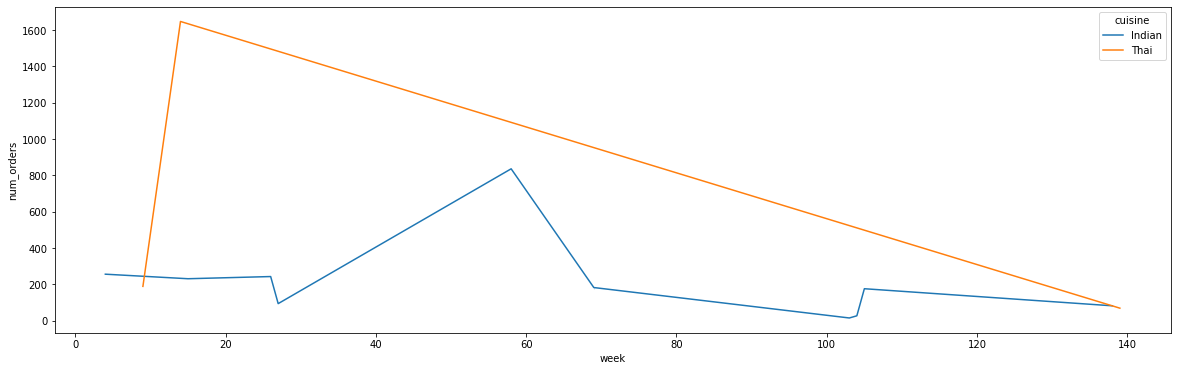

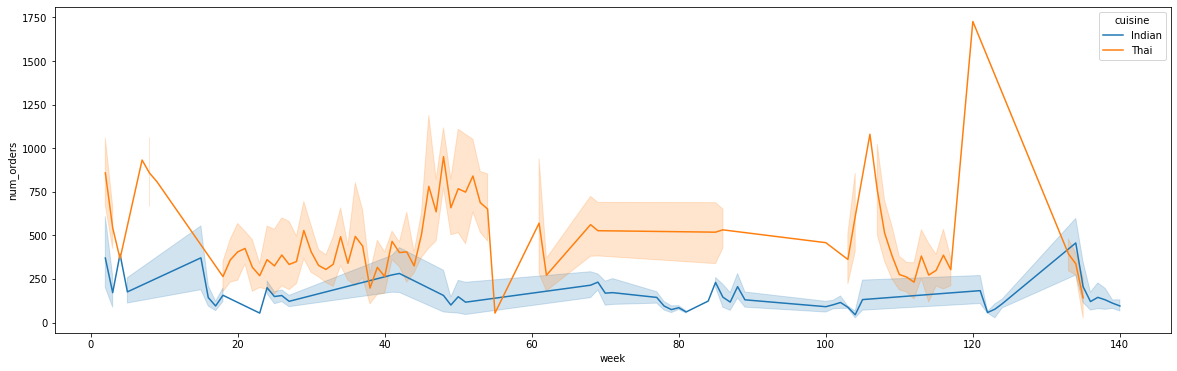

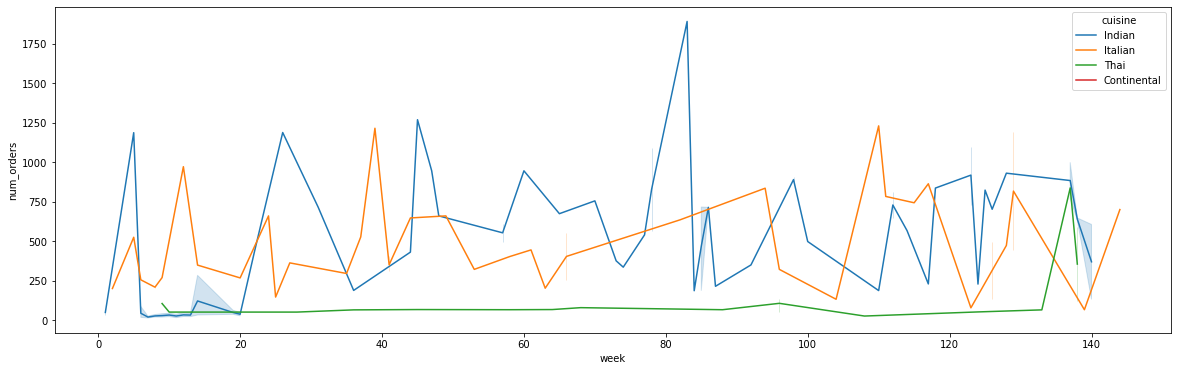

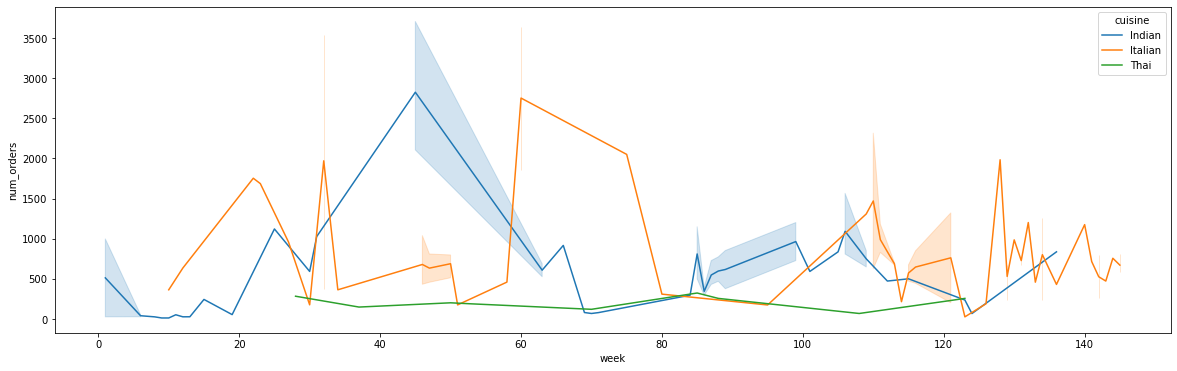

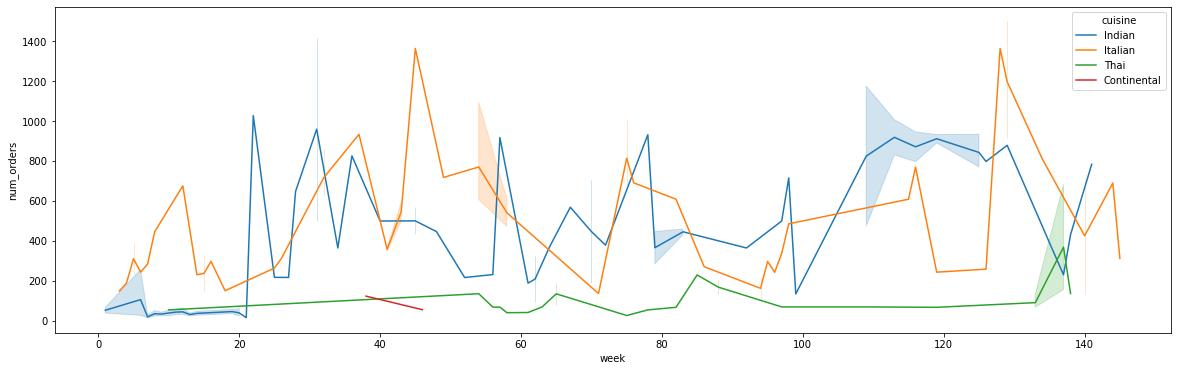

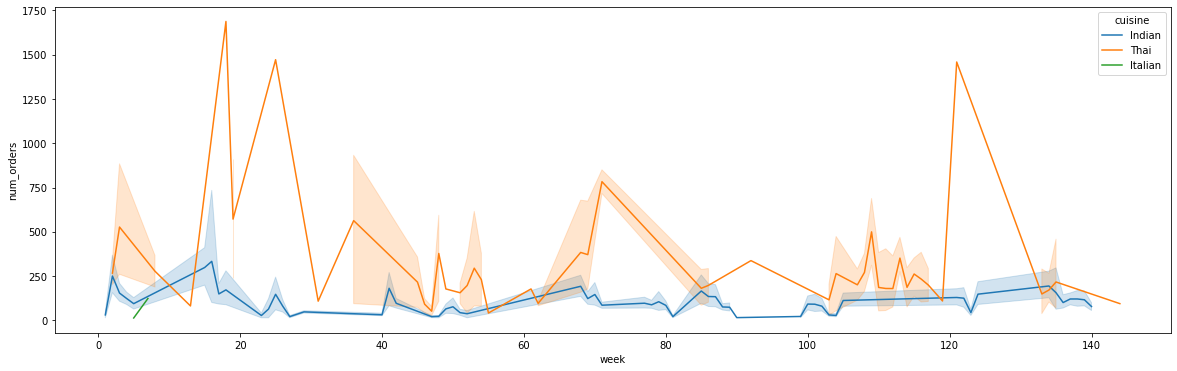

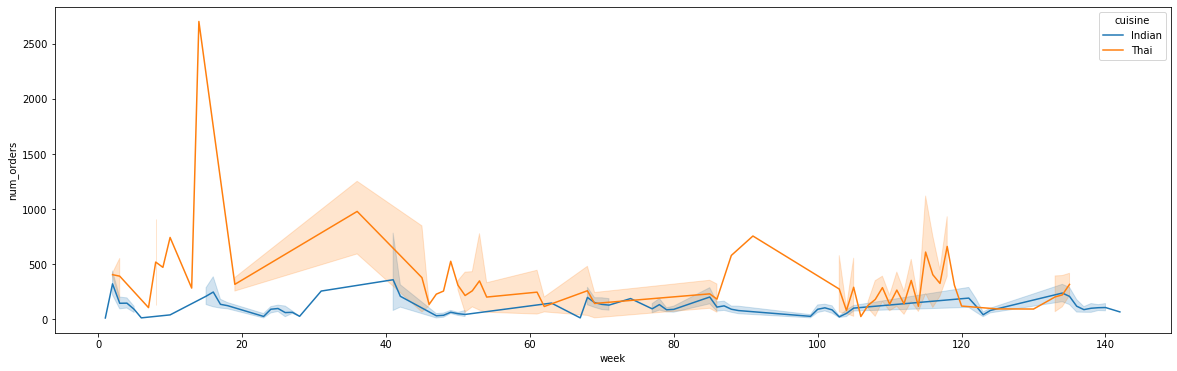

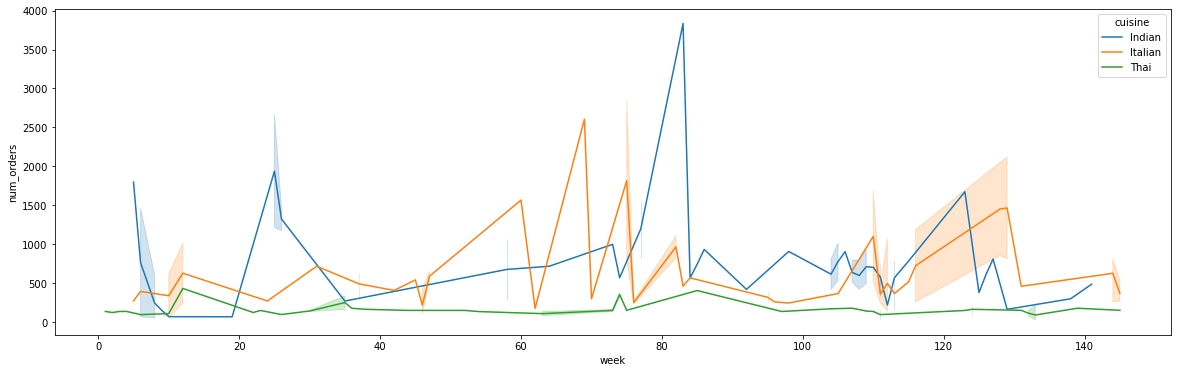

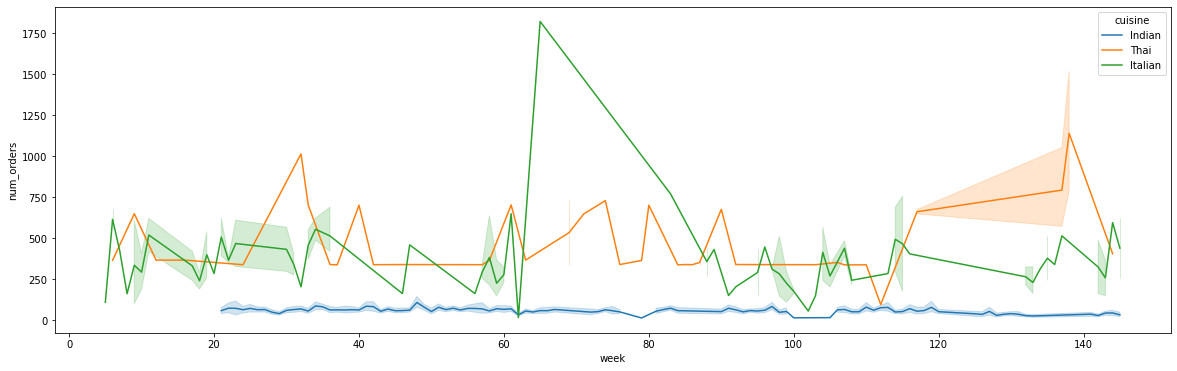

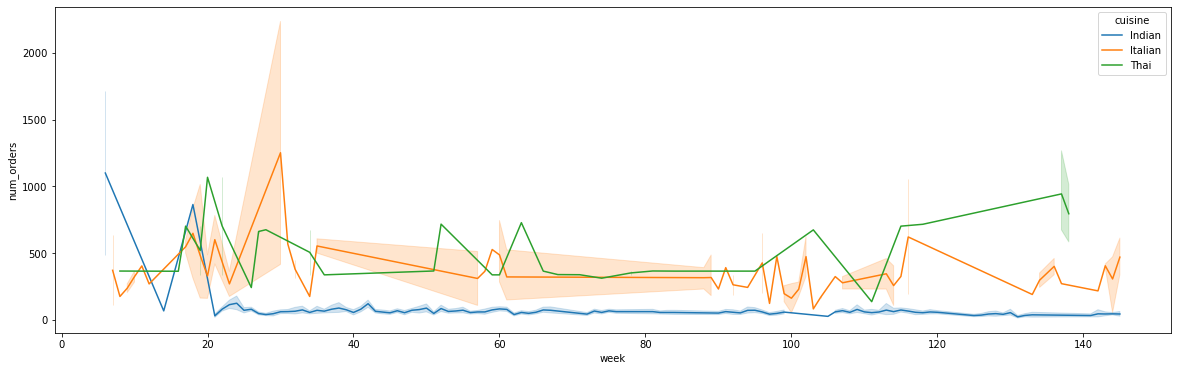

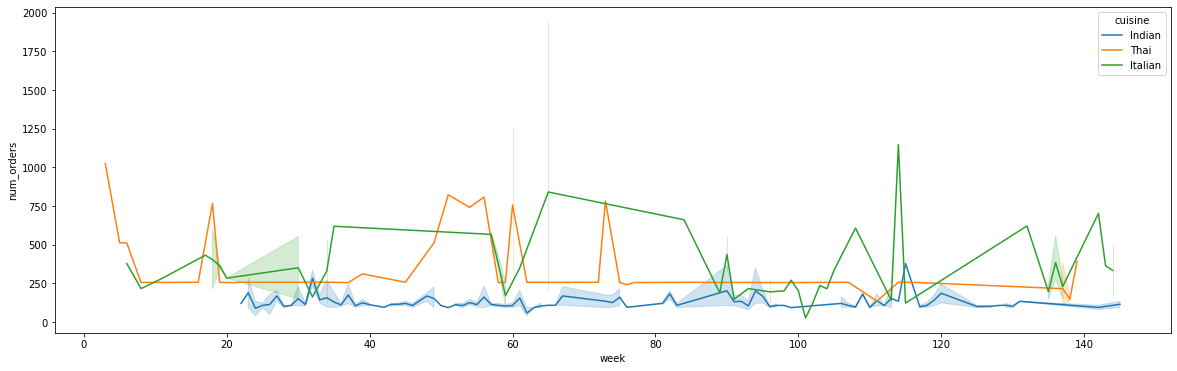

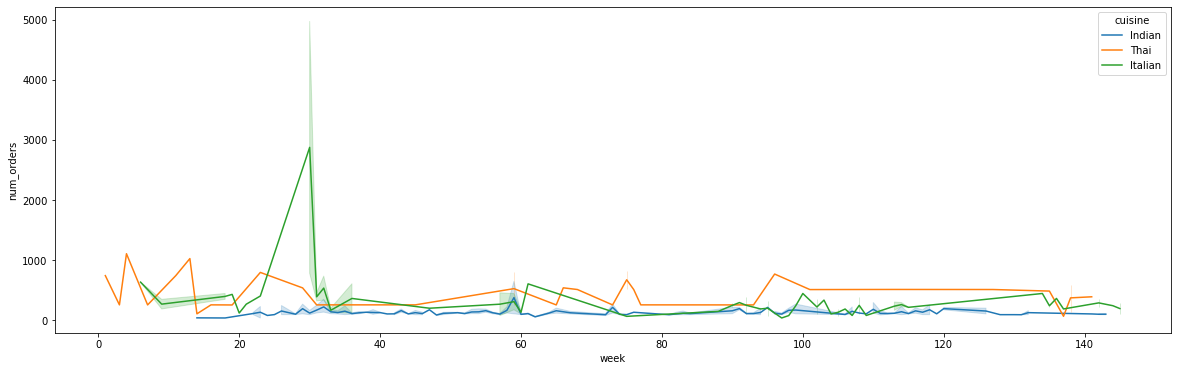

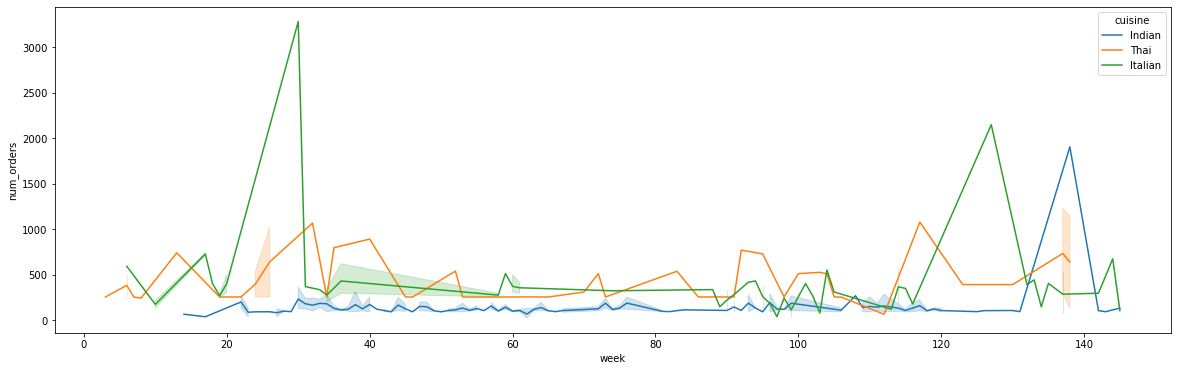

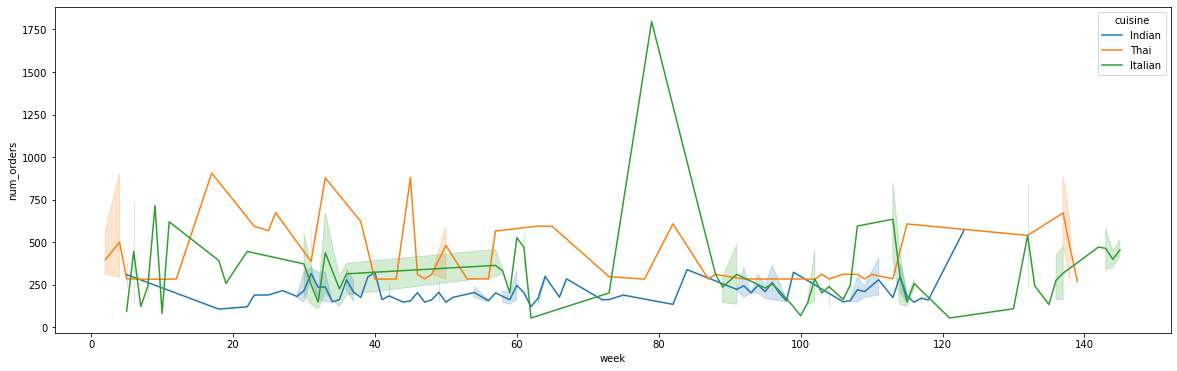

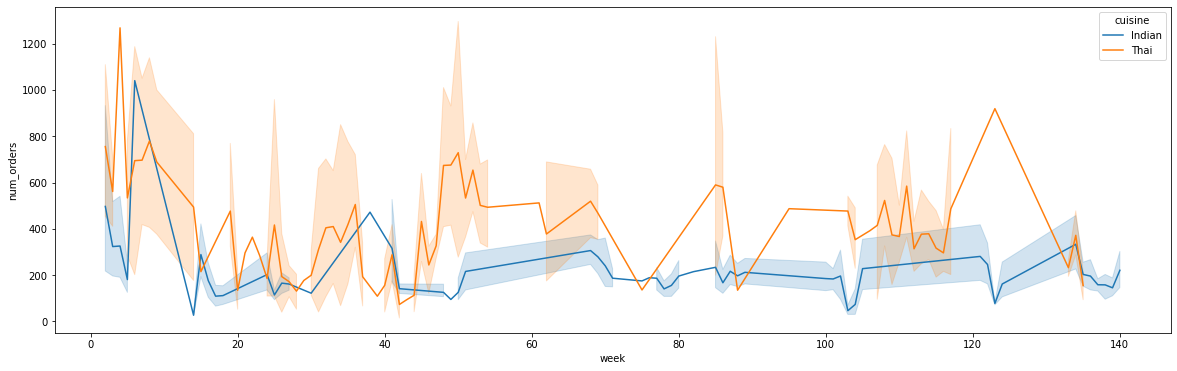

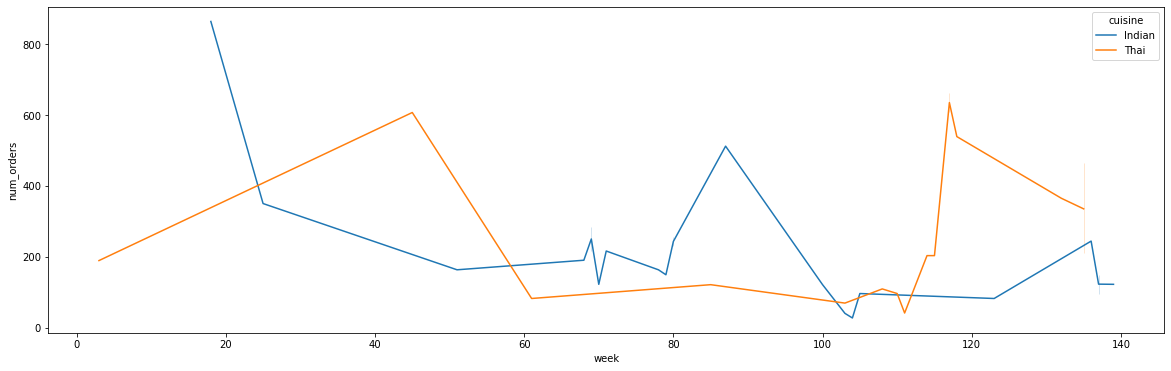

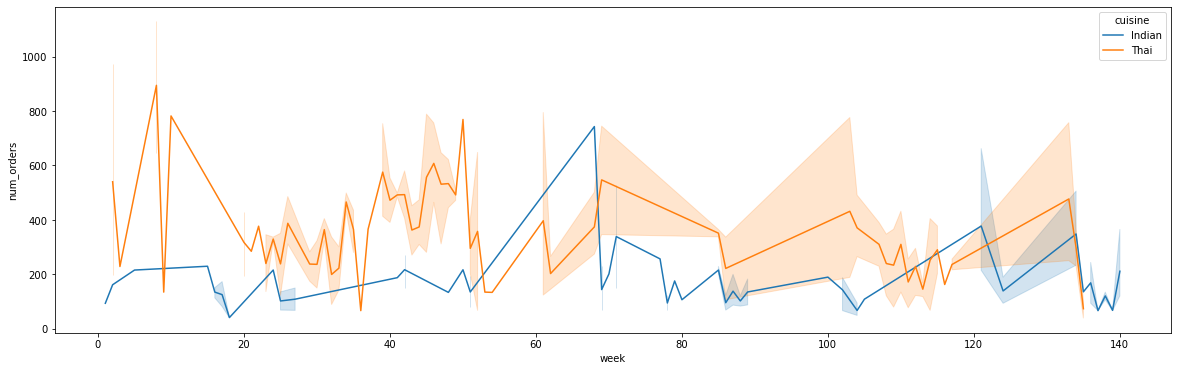

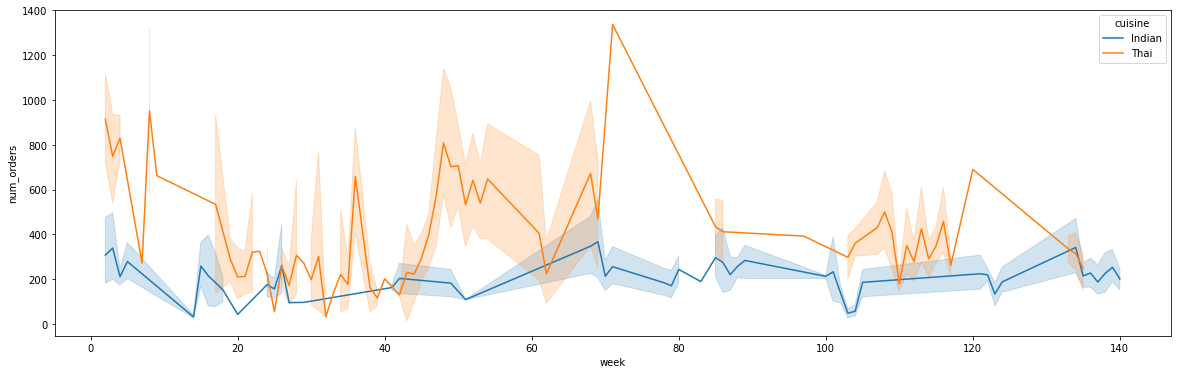

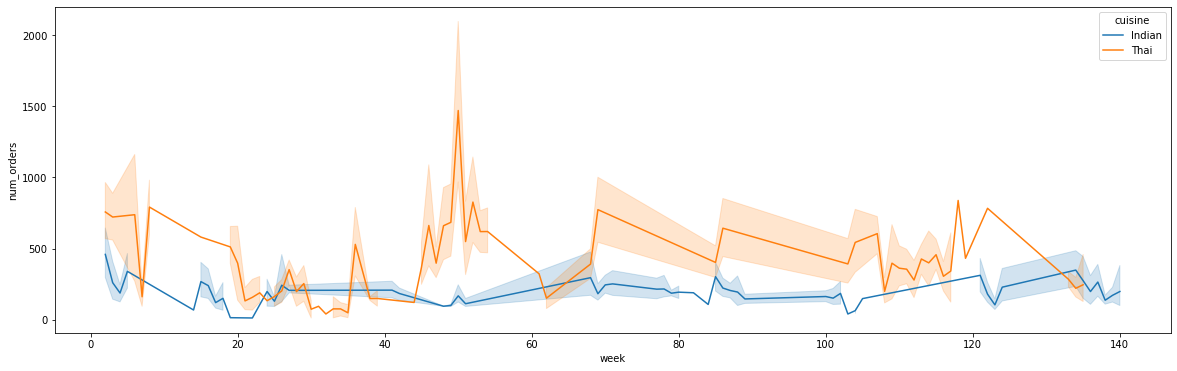

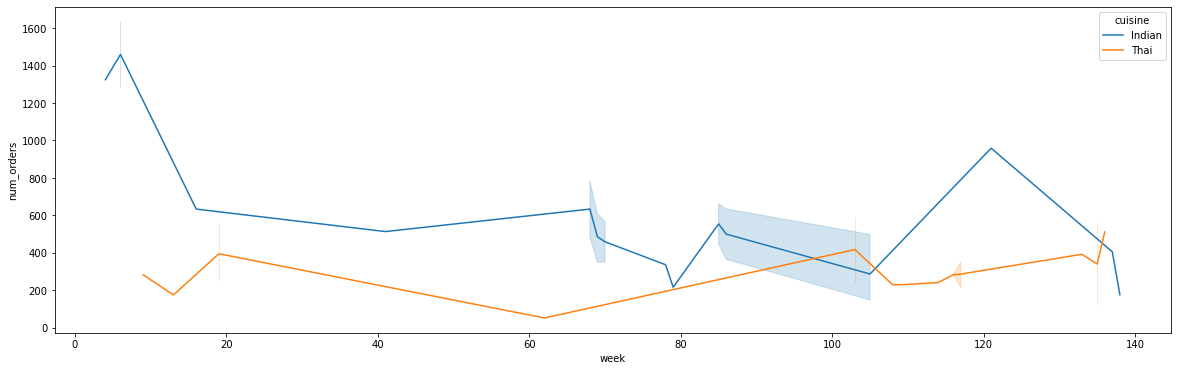

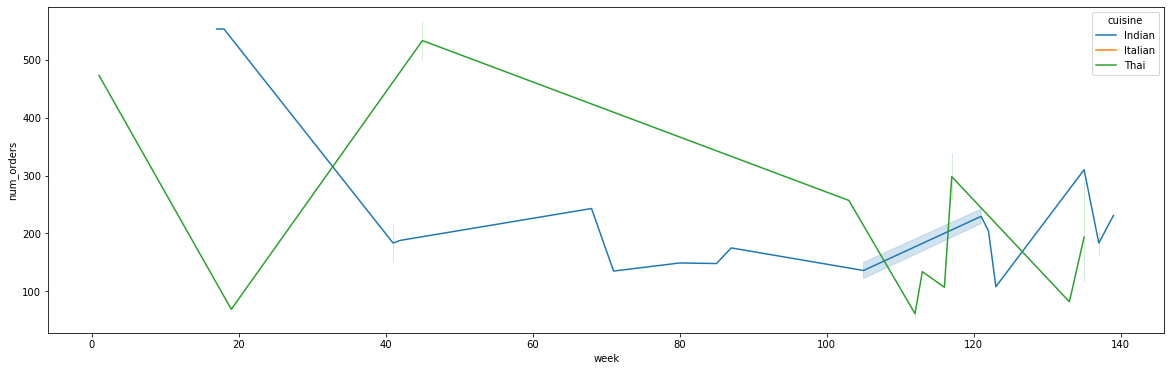

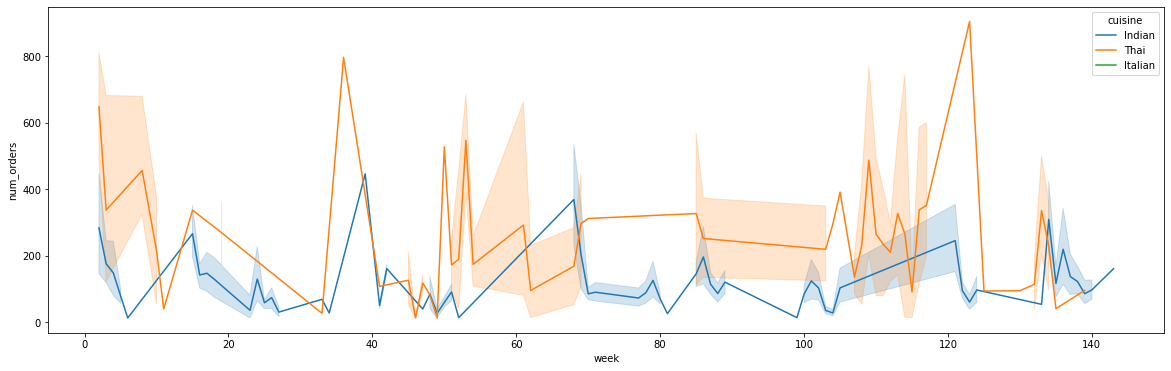

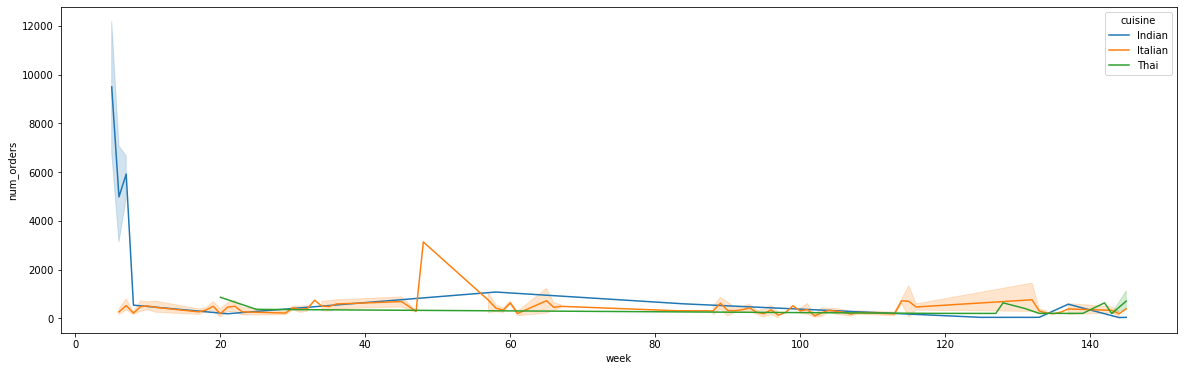

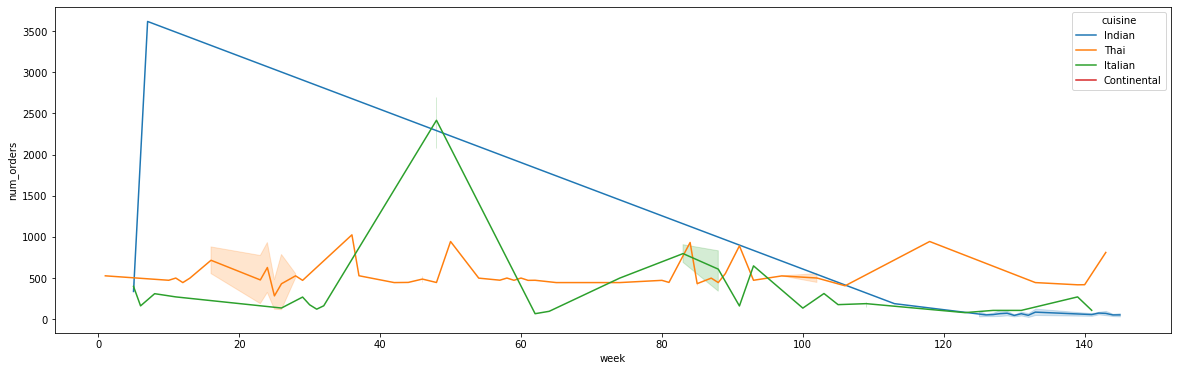

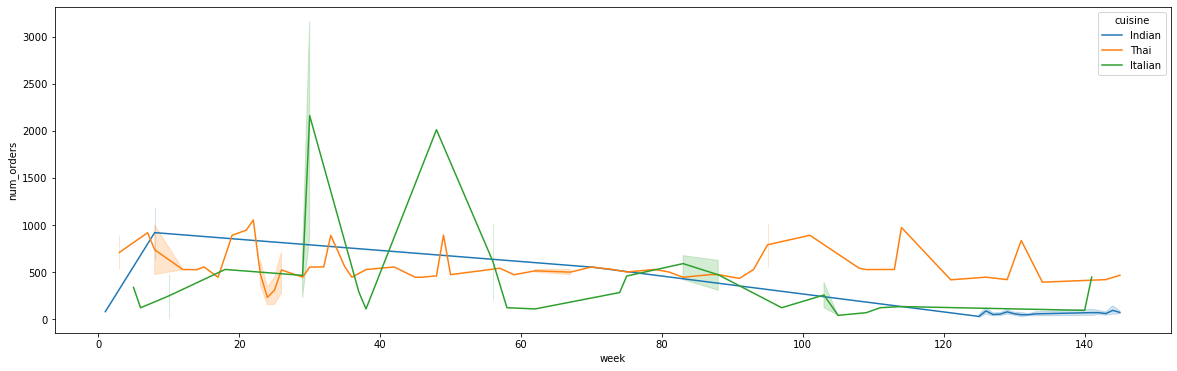

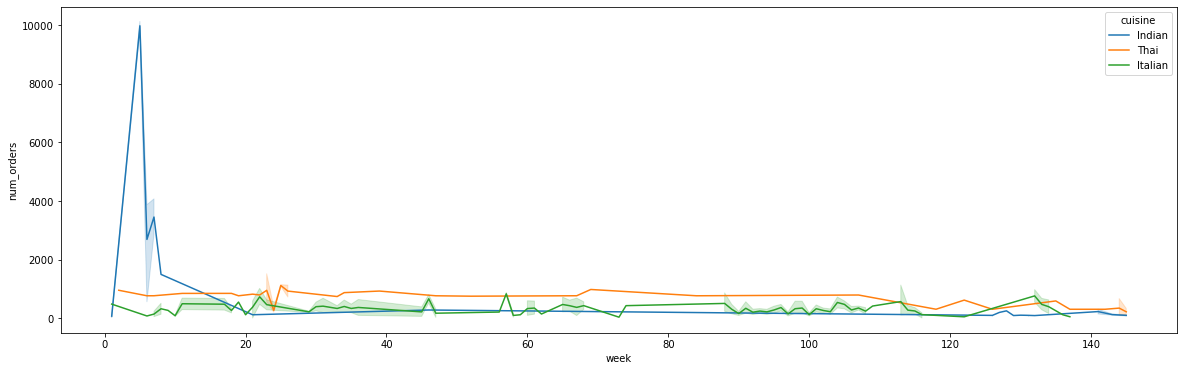

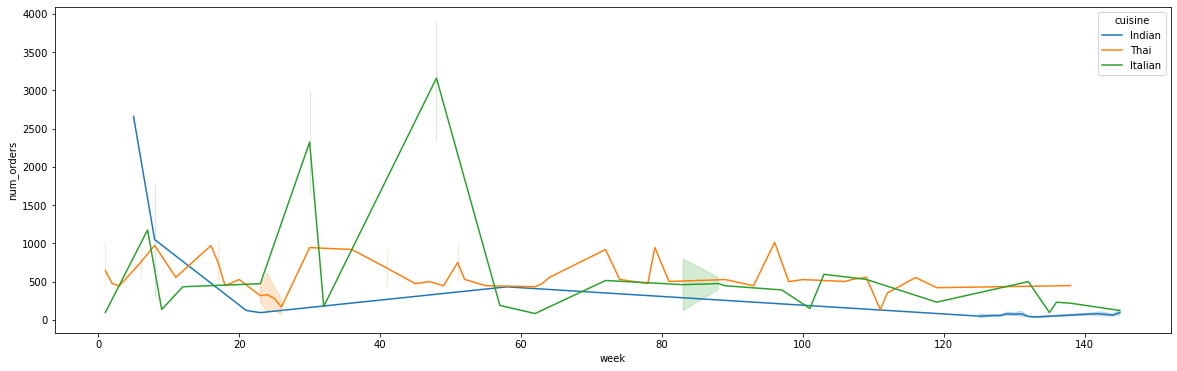

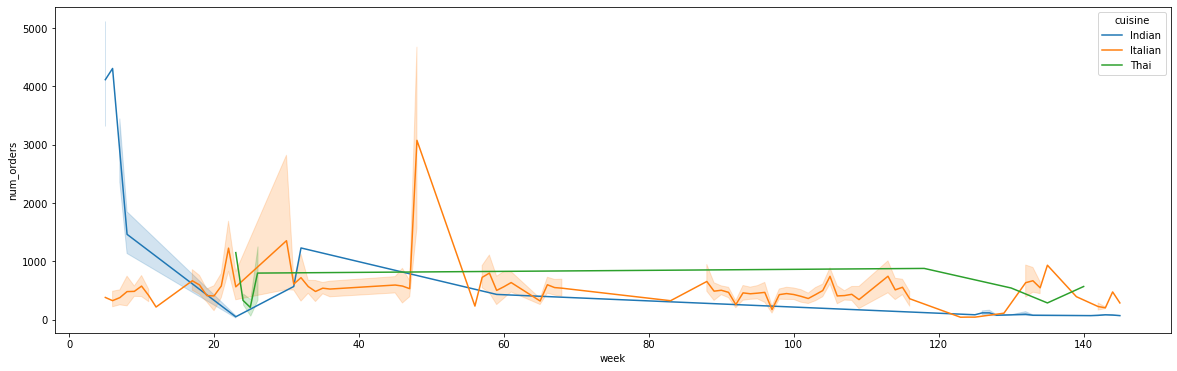

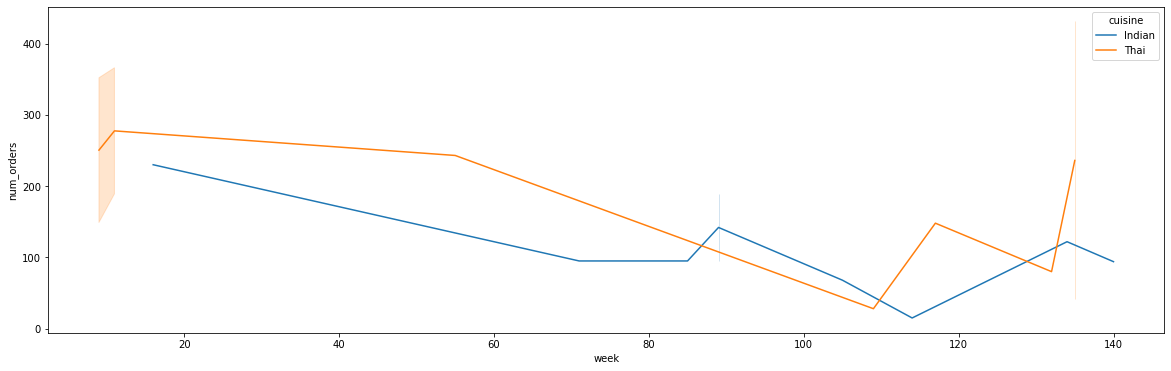

In [ ]:
for price in train['checkout_price'].unique():
    plt.figure(figsize=(20,6))
    sns.lineplot(data=train[train['checkout_price']==price],x='week',y='num_orders',hue='cuisine')
    plt.show()

In [43]:
for col in train.columns:
    print(col,len(train[col].unique()) ,train[col].unique())
    

id 456548 [1379560 1040403 1103215 ... 1434028 1205895 1443704]
week 145 [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145]
center_id 77 [ 55  24  11  83  32  13 109  52  93 186 146  57 149  89 124 152  97  74
 108  99  66  94  91  20  34 137  92 126  36 162  75 177  27 157 106  64
 129  14  17 153 139 161  81  26  73  50 104  42 113 145  53  72  67 174
  29  77  41  30  76  59  88 143  58  10 101  80  43  65  39 102 110 132
  23  86  68  51  61]
meal_id 51